In [1]:
import pandas as pd
import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from multiprocessing import cpu_count, Pool

In [2]:
tr = pd.read_pickle('../data/train.pkl')
tr_log = pd.read_pickle('../data/train_log.pkl')

In [3]:
tr.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [4]:
tr.tail()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
7843,130739978,26.718750,-14.940303,172.342697,-72.255675,0,0.0000,0.0000,0.0000,NaN,0.013,65
7844,130755807,120.101349,-62.696659,275.742955,-16.509746,0,0.1725,2.5606,1.1146,46.6108,0.136,90
7845,130762946,203.108109,-55.682144,308.728904,6.727511,0,0.0000,0.0000,0.0000,NaN,0.430,16
7846,130772921,79.101562,-35.501846,239.172243,-33.827844,0,0.0000,0.0000,0.0000,NaN,0.034,65
7847,130779836,301.992188,-17.426323,25.102988,-24.511101,0,0.0000,0.0000,0.0000,NaN,0.091,6


In [5]:
tr_log.head(20)

,object_id,mjd,passband,flux,flux_err,detected,date,year,month,3month,flux_norm1,flux_norm2
0,615,59750.421875,2,-544.810303,3.622952,1,59750,0,0,0,-0.824688,0.841065
1,615,59750.429688,1,-816.434326,5.553370,1,59750,0,0,0,-1.235849,0.429904
2,615,59750.437500,3,-471.385529,3.801213,1,59750,0,0,0,-0.713543,0.952209
3,615,59750.445312,4,-388.984985,11.395031,1,59750,0,0,0,-0.588812,1.076940
4,615,59752.406250,2,-681.858887,4.041204,1,59752,0,0,0,-1.032140,0.633613
5,615,59752.414062,1,-1061.457031,6.472994,1,59752,0,0,0,-1.606743,0.059009
6,615,59752.421875,3,-524.954590,3.552751,1,59752,0,0,0,-0.794632,0.871121
7,615,59752.433594,4,-393.480225,3.599346,1,59752,0,0,0,-0.595617,1.070136
8,615,59752.445312,5,-355.886780,10.421921,1,59752,0,0,0,-0.538711,1.127041
9,615,59767.296875,2,-548.013550,3.462291,1,59767,0,0,0,-0.829536,0.836216


In [6]:
def plt_obj(oid=None, save=False, path=None, norm=False, return_df=False):
    if oid is None:
        oid = np.random.choice(tr.object_id)
    df = tr_log[tr_log.object_id==oid]
    if norm:
        df.flux /= df.flux.max()
    target = tr.loc[tr.object_id==oid, 'target'].values[0]
    photoz = tr.loc[tr.object_id==oid, 'hostgal_photoz'].values[0]
    
    df['date'] = df.mjd.astype(int)
    
    df = pd.pivot_table(df, index=['date'], columns=['passband'], values=['detected'])
    if return_df:
        return df
    
    df.plot(marker="o", legend=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'oid:{oid}    target:{target}    photoz:{photoz}')
    if save==True and path is not None:
        plt.savefig(path)
    return


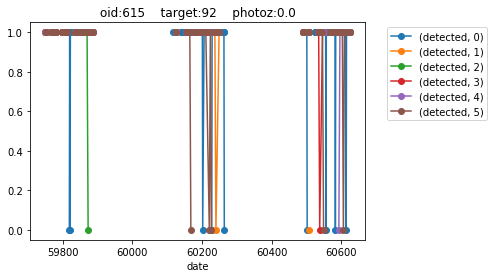

In [7]:
plt_obj(615)

100%|██████████| 14/14 [03:14<00:00, 13.89s/it]


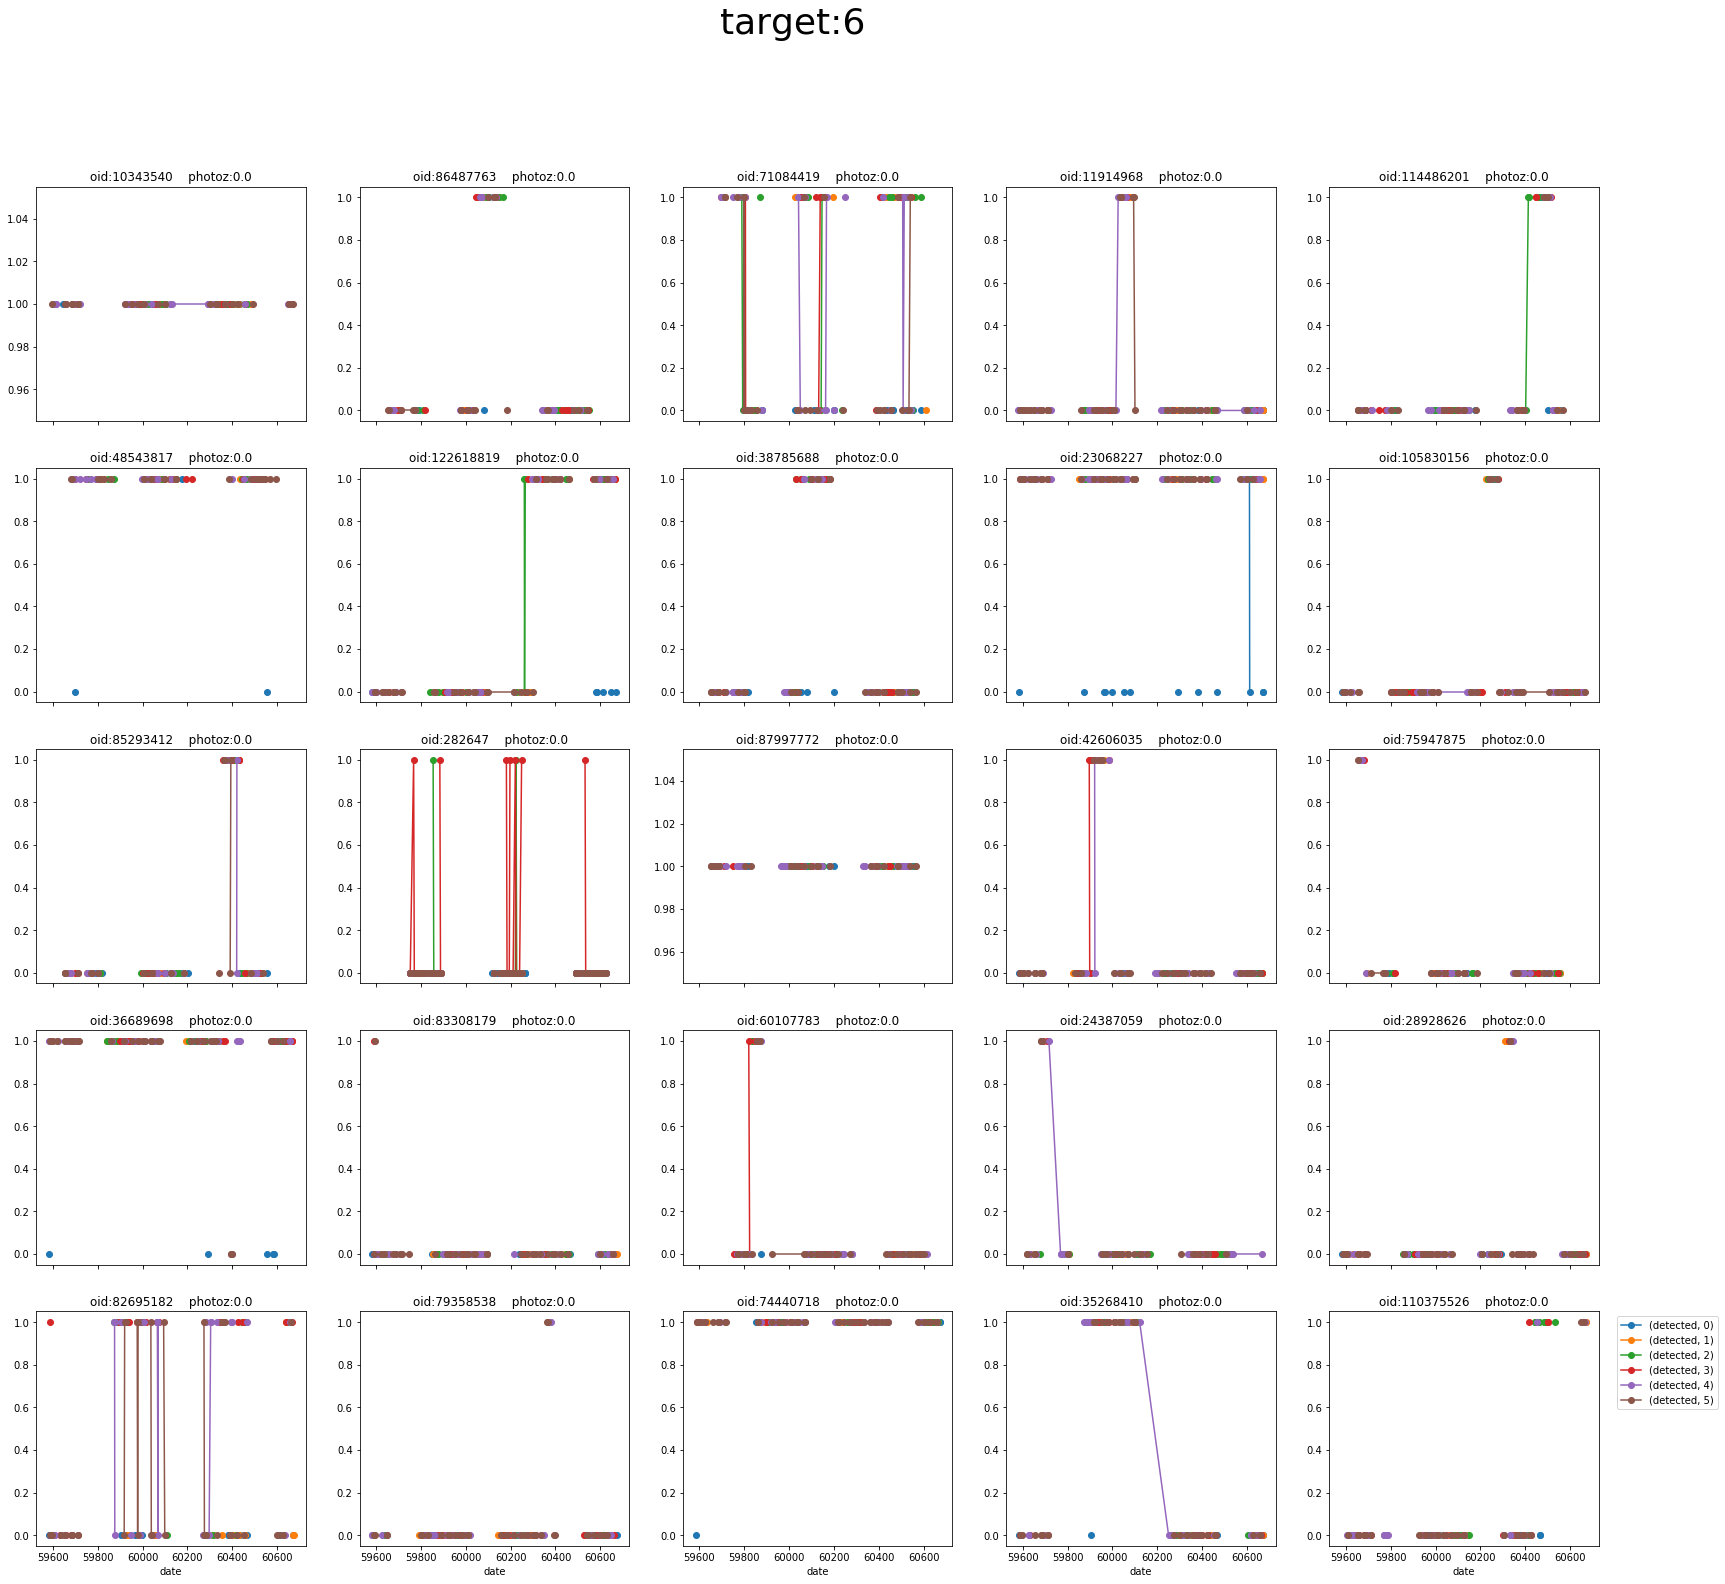

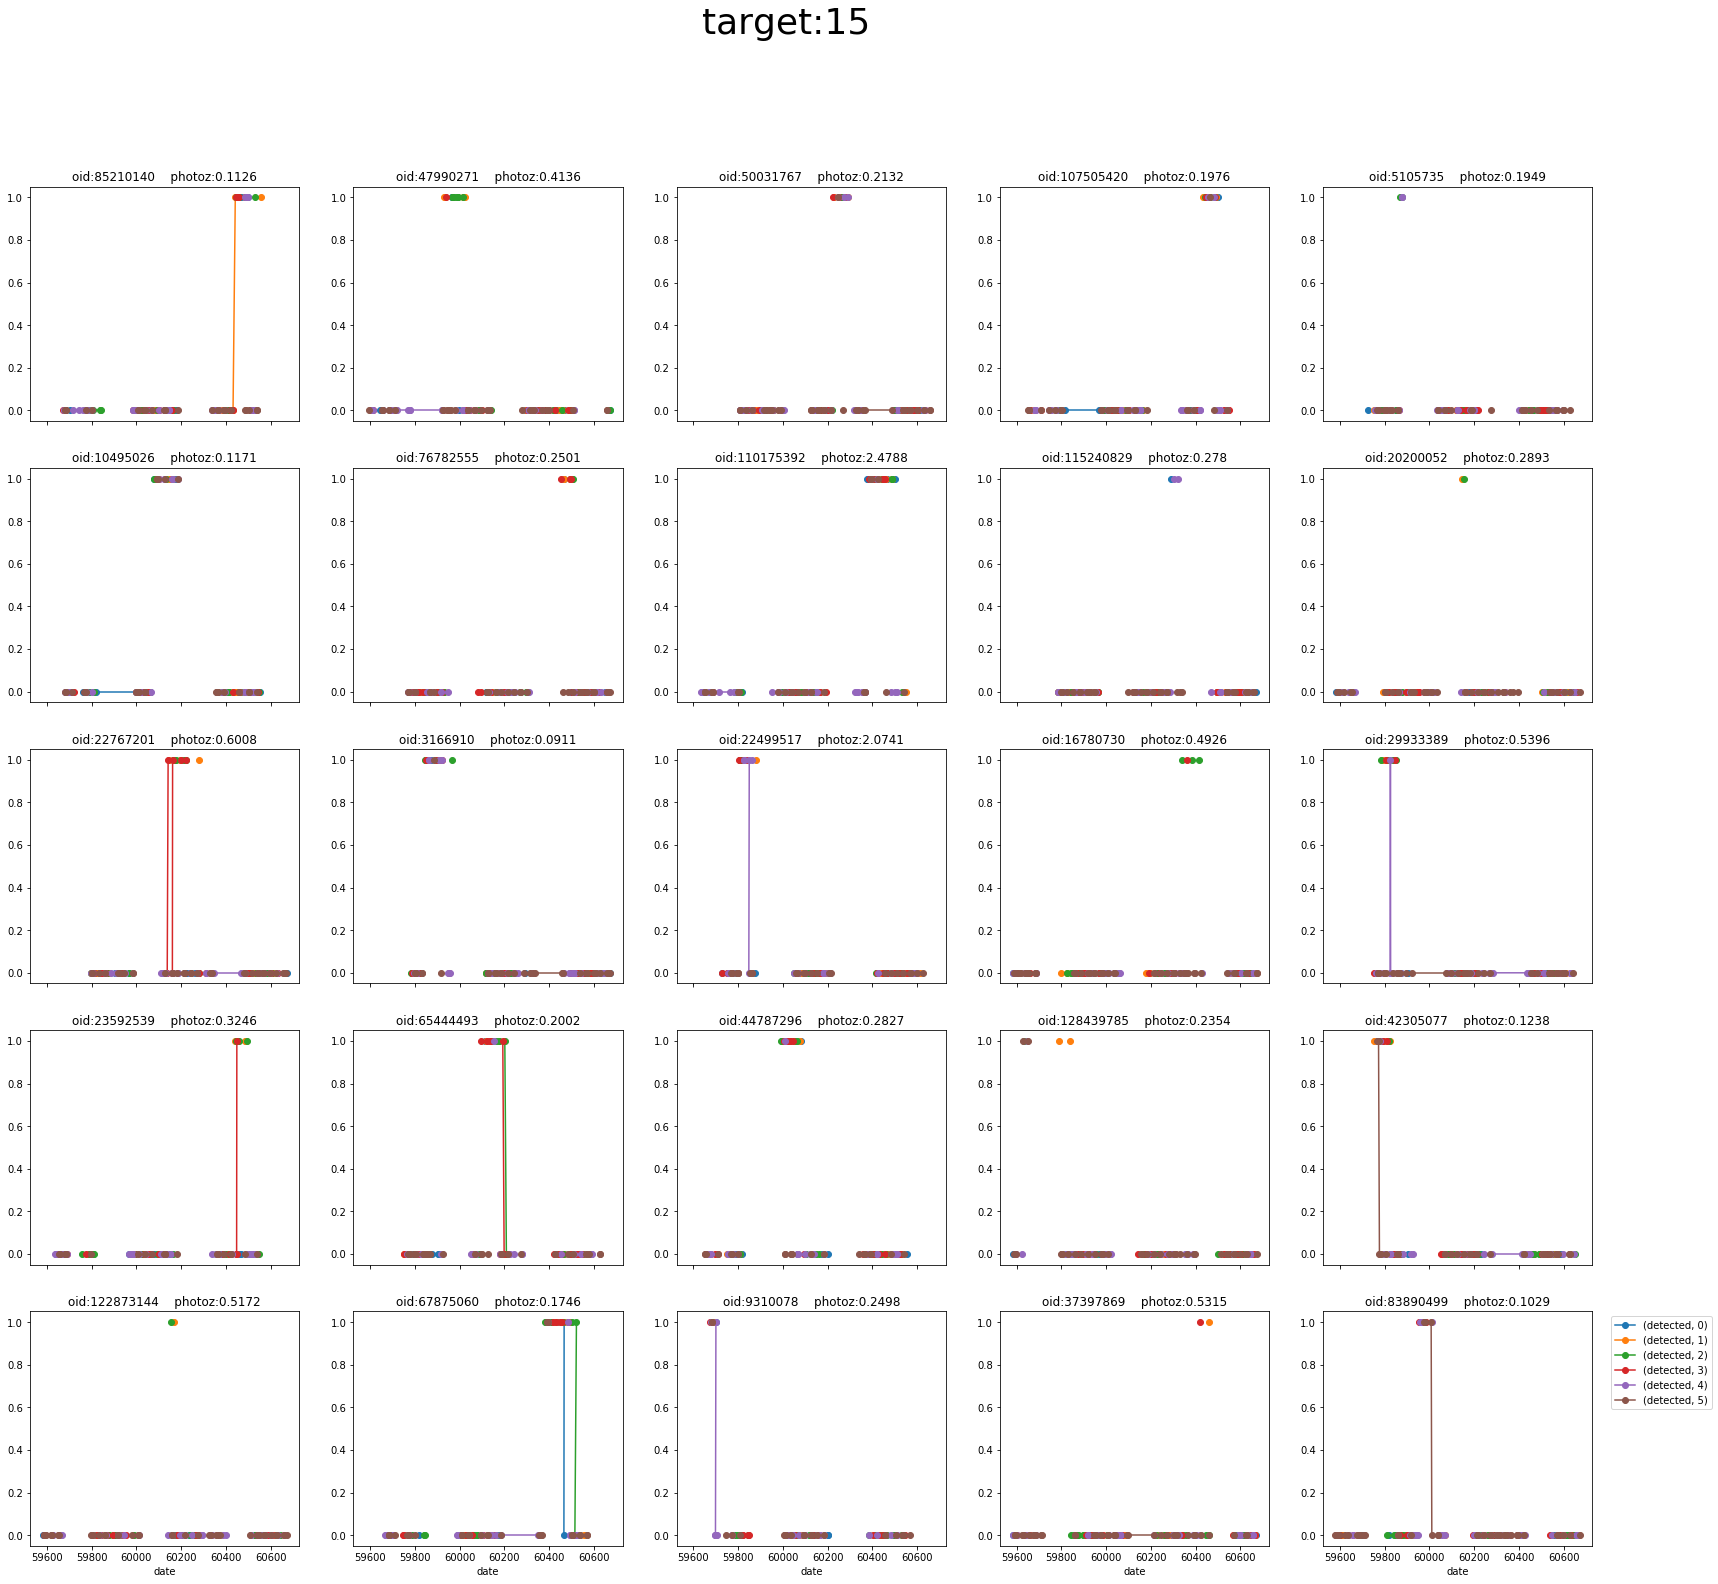

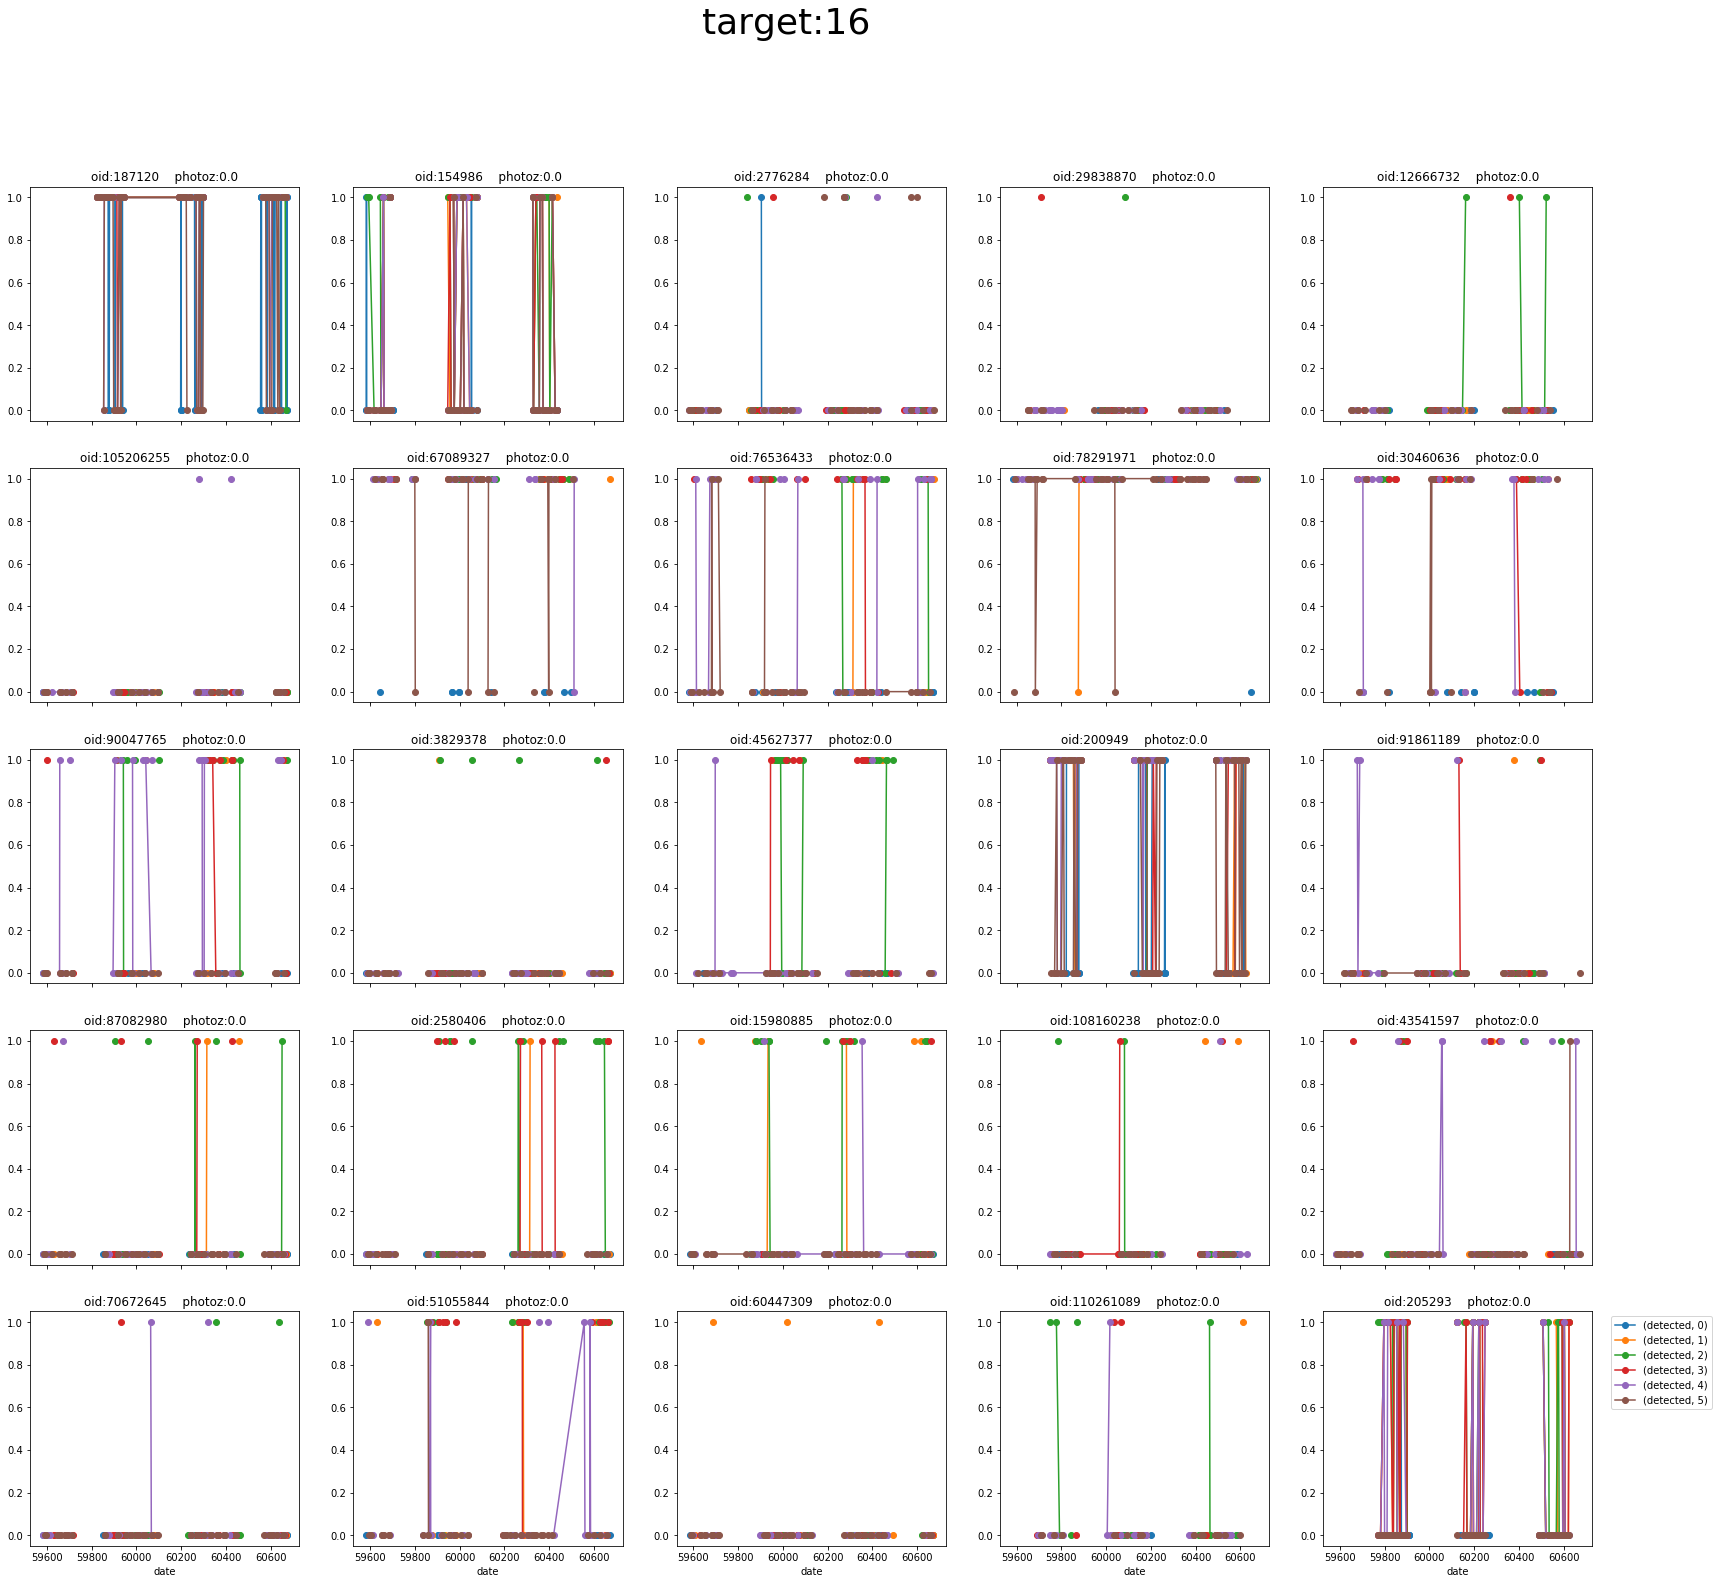

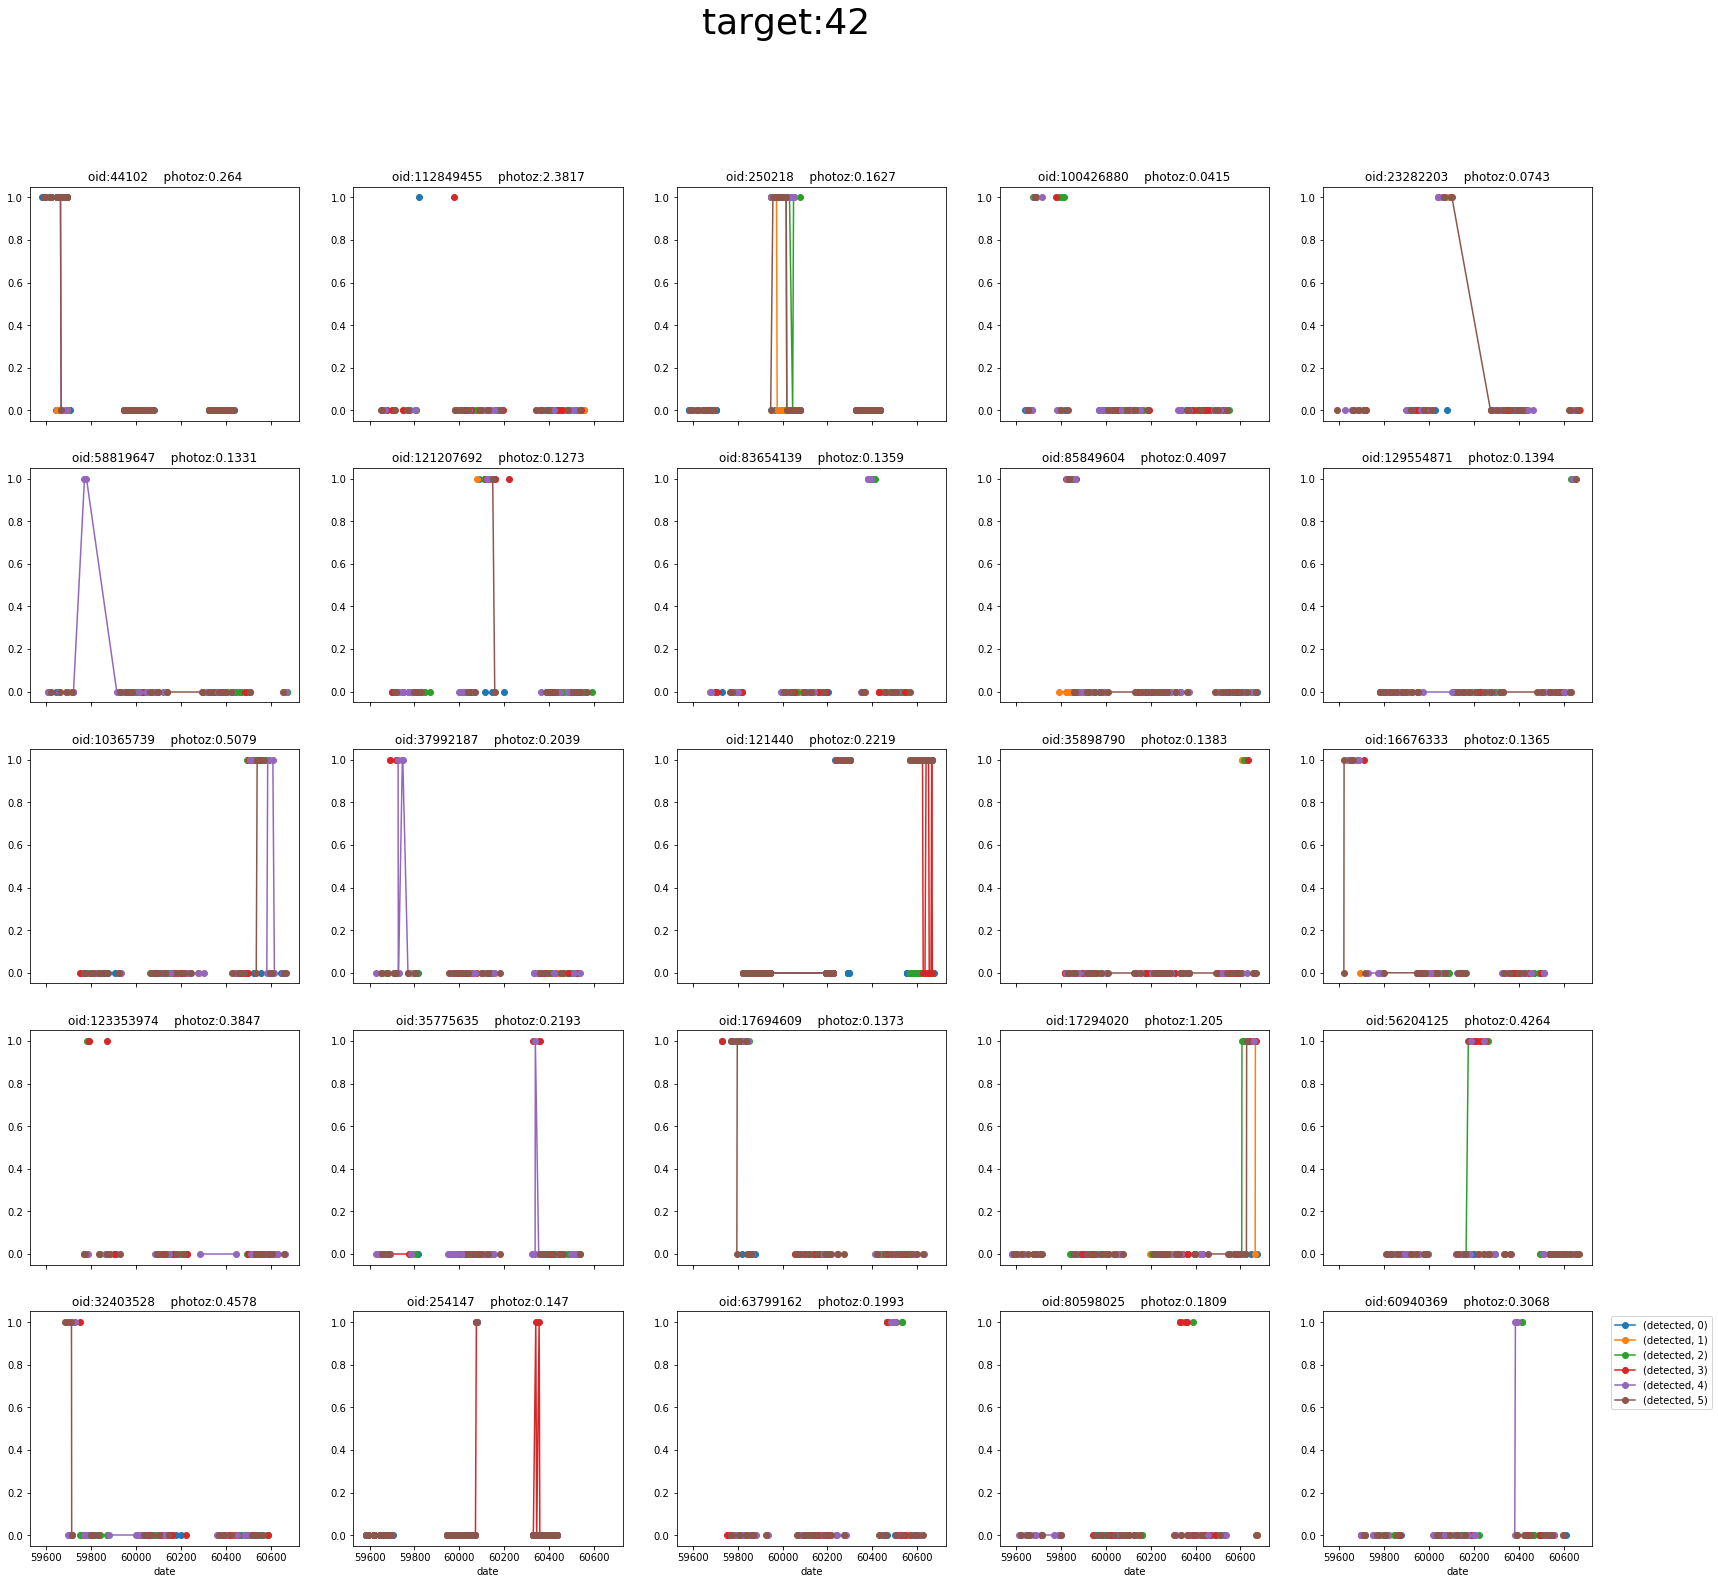

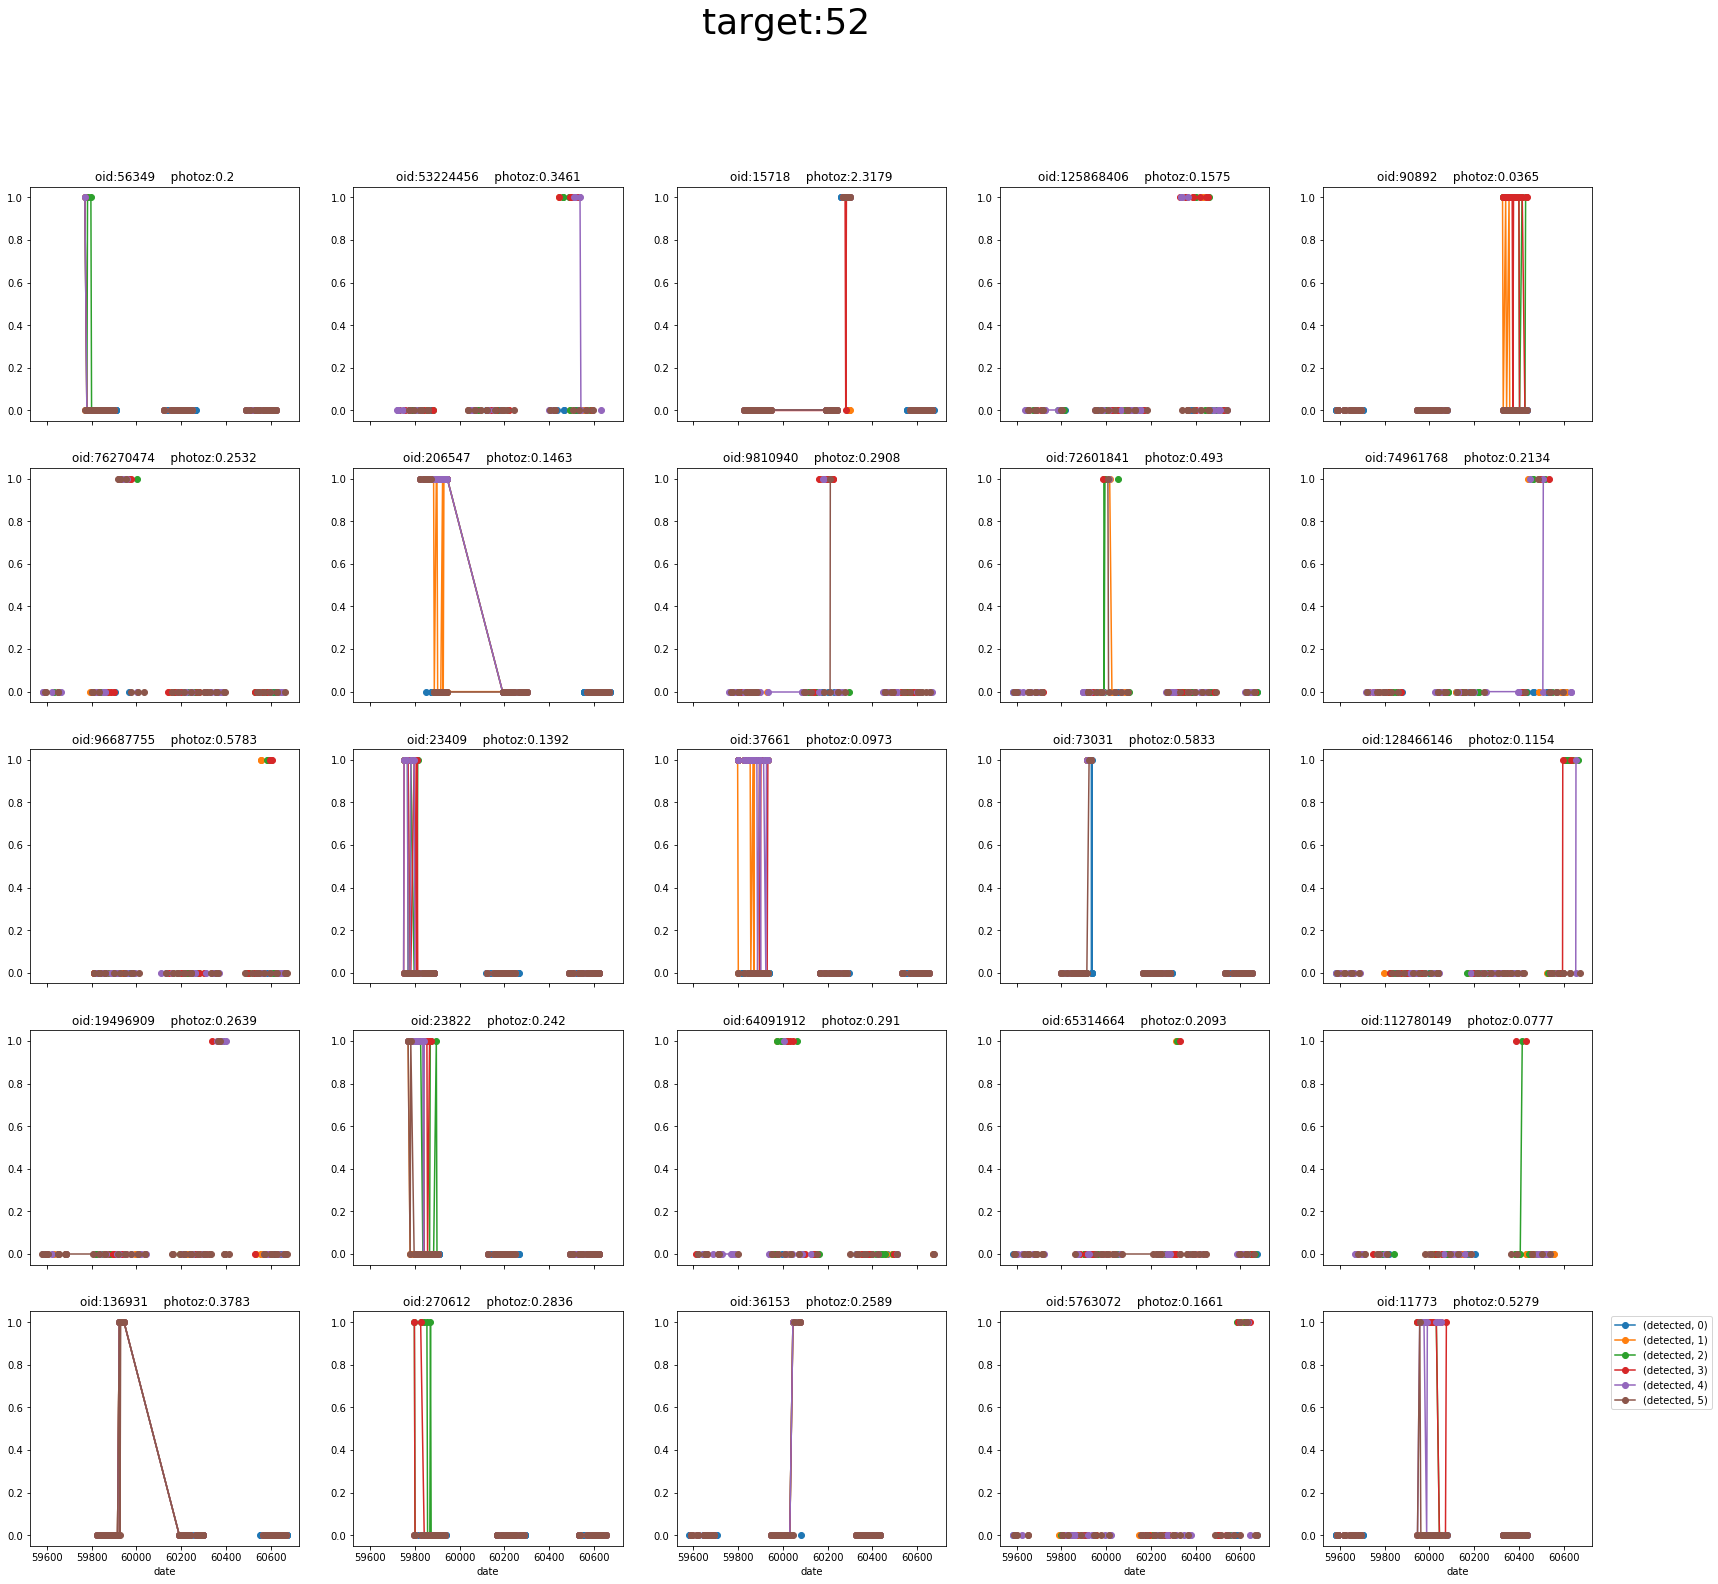

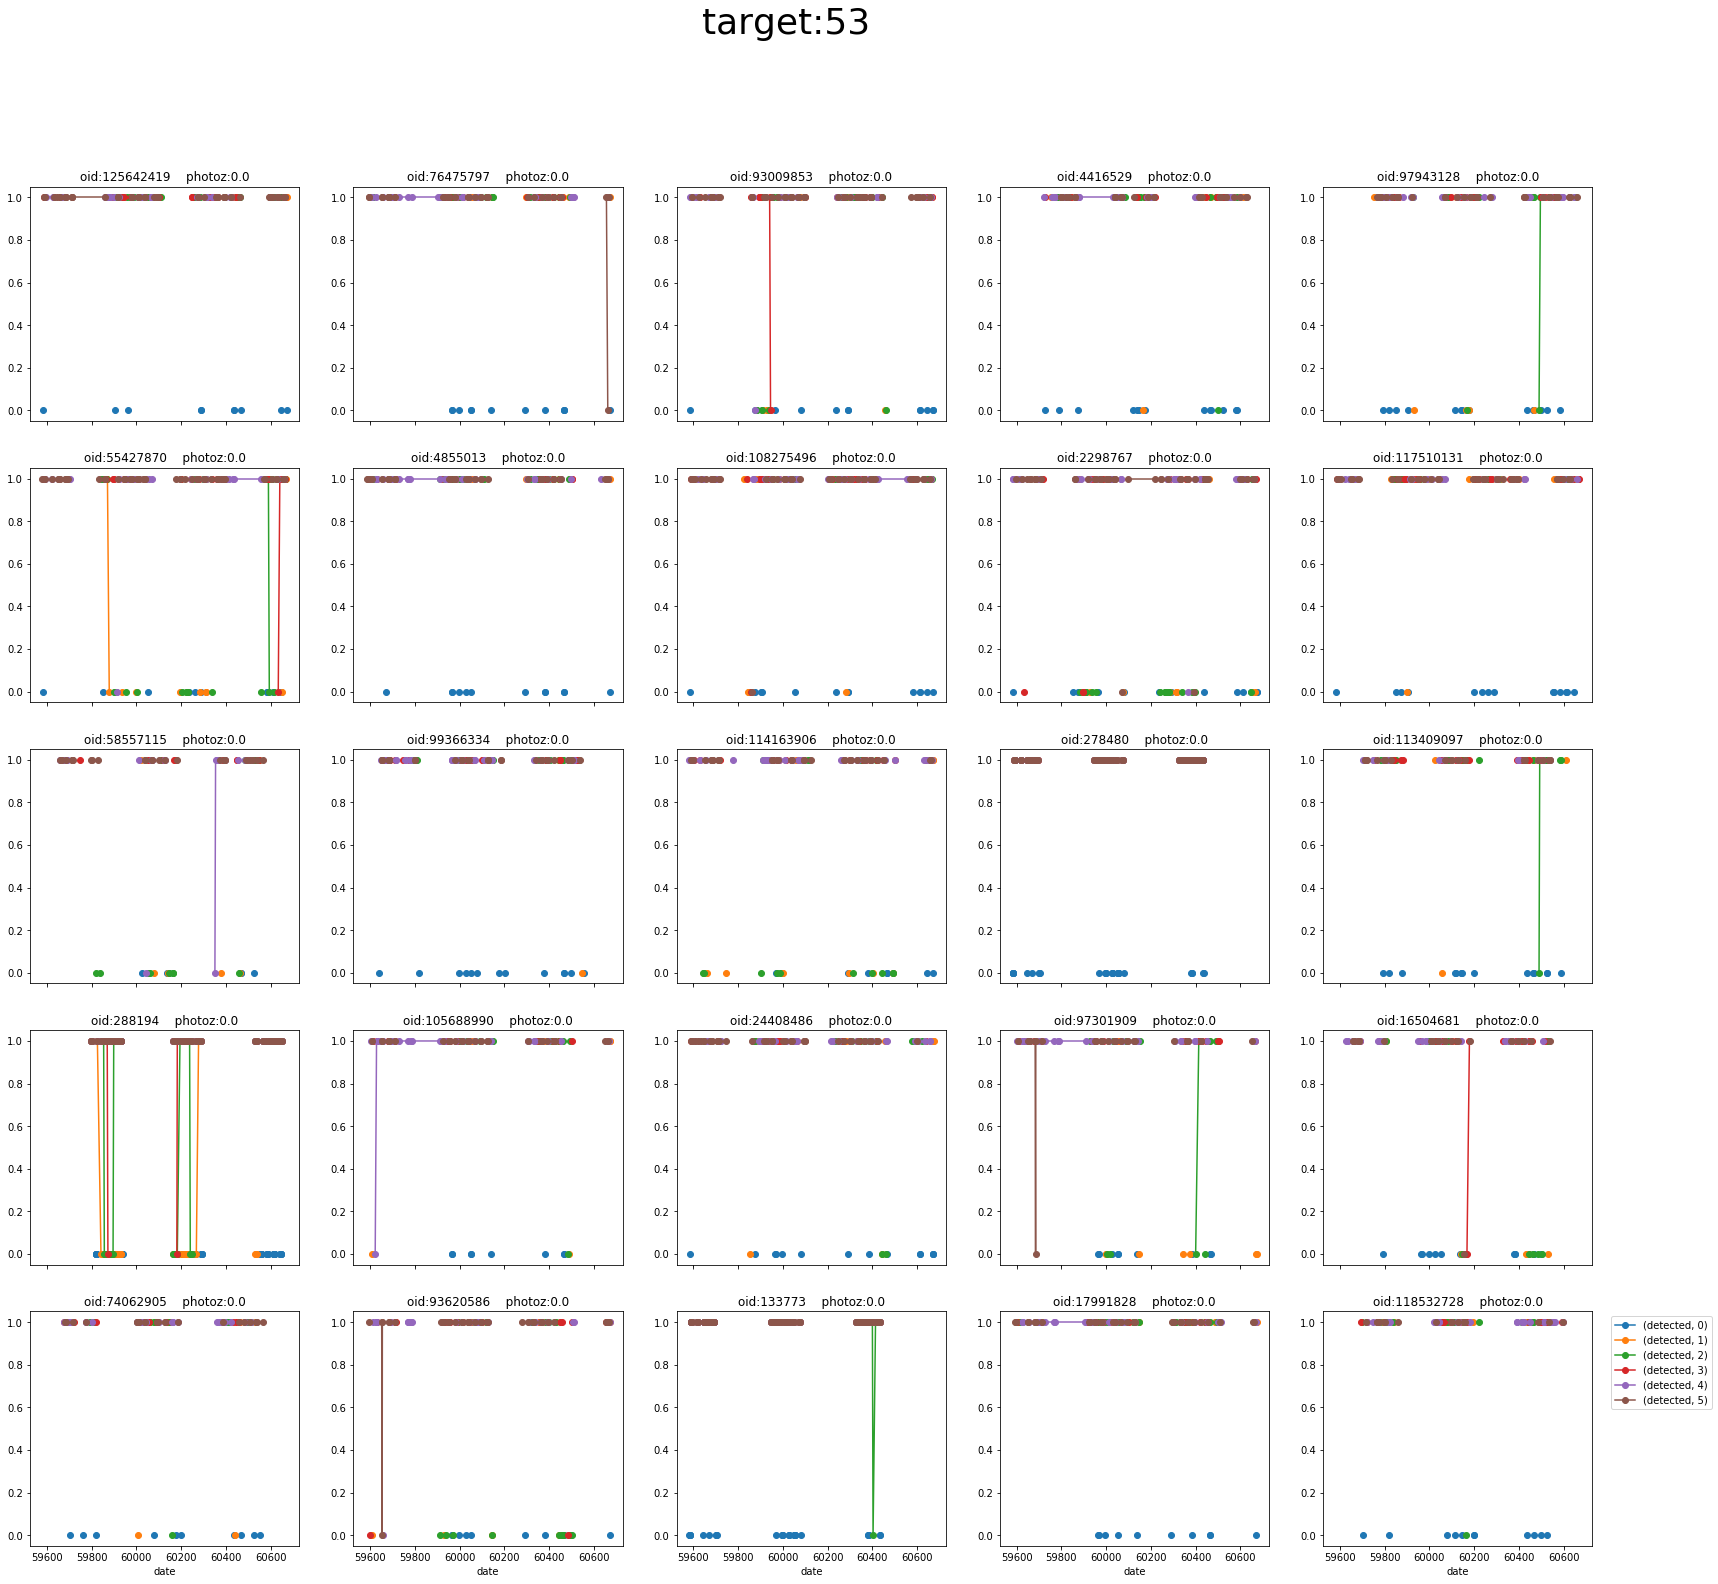

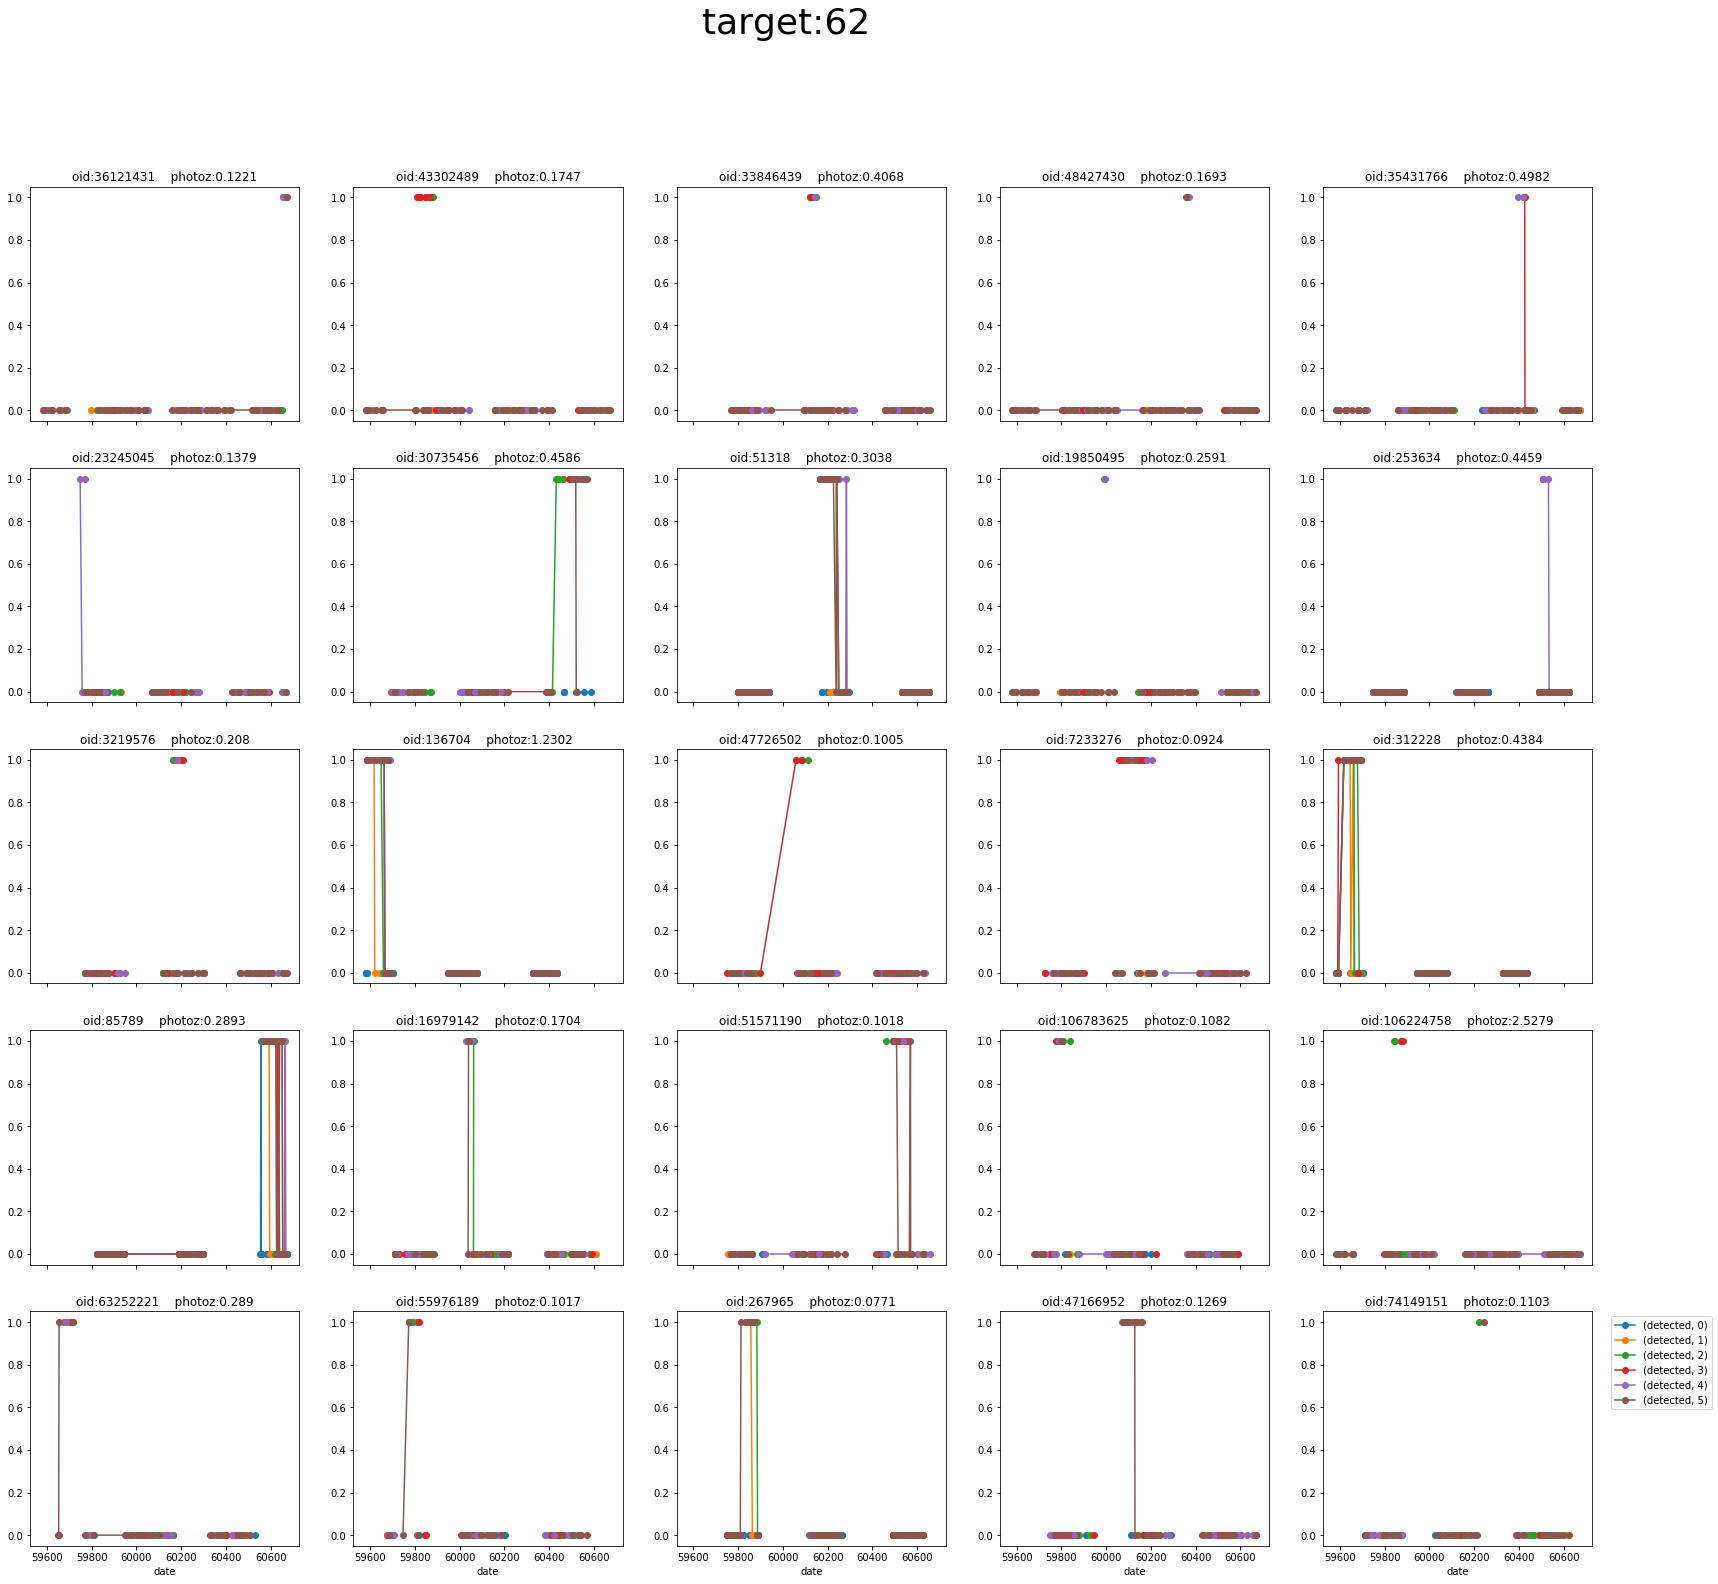

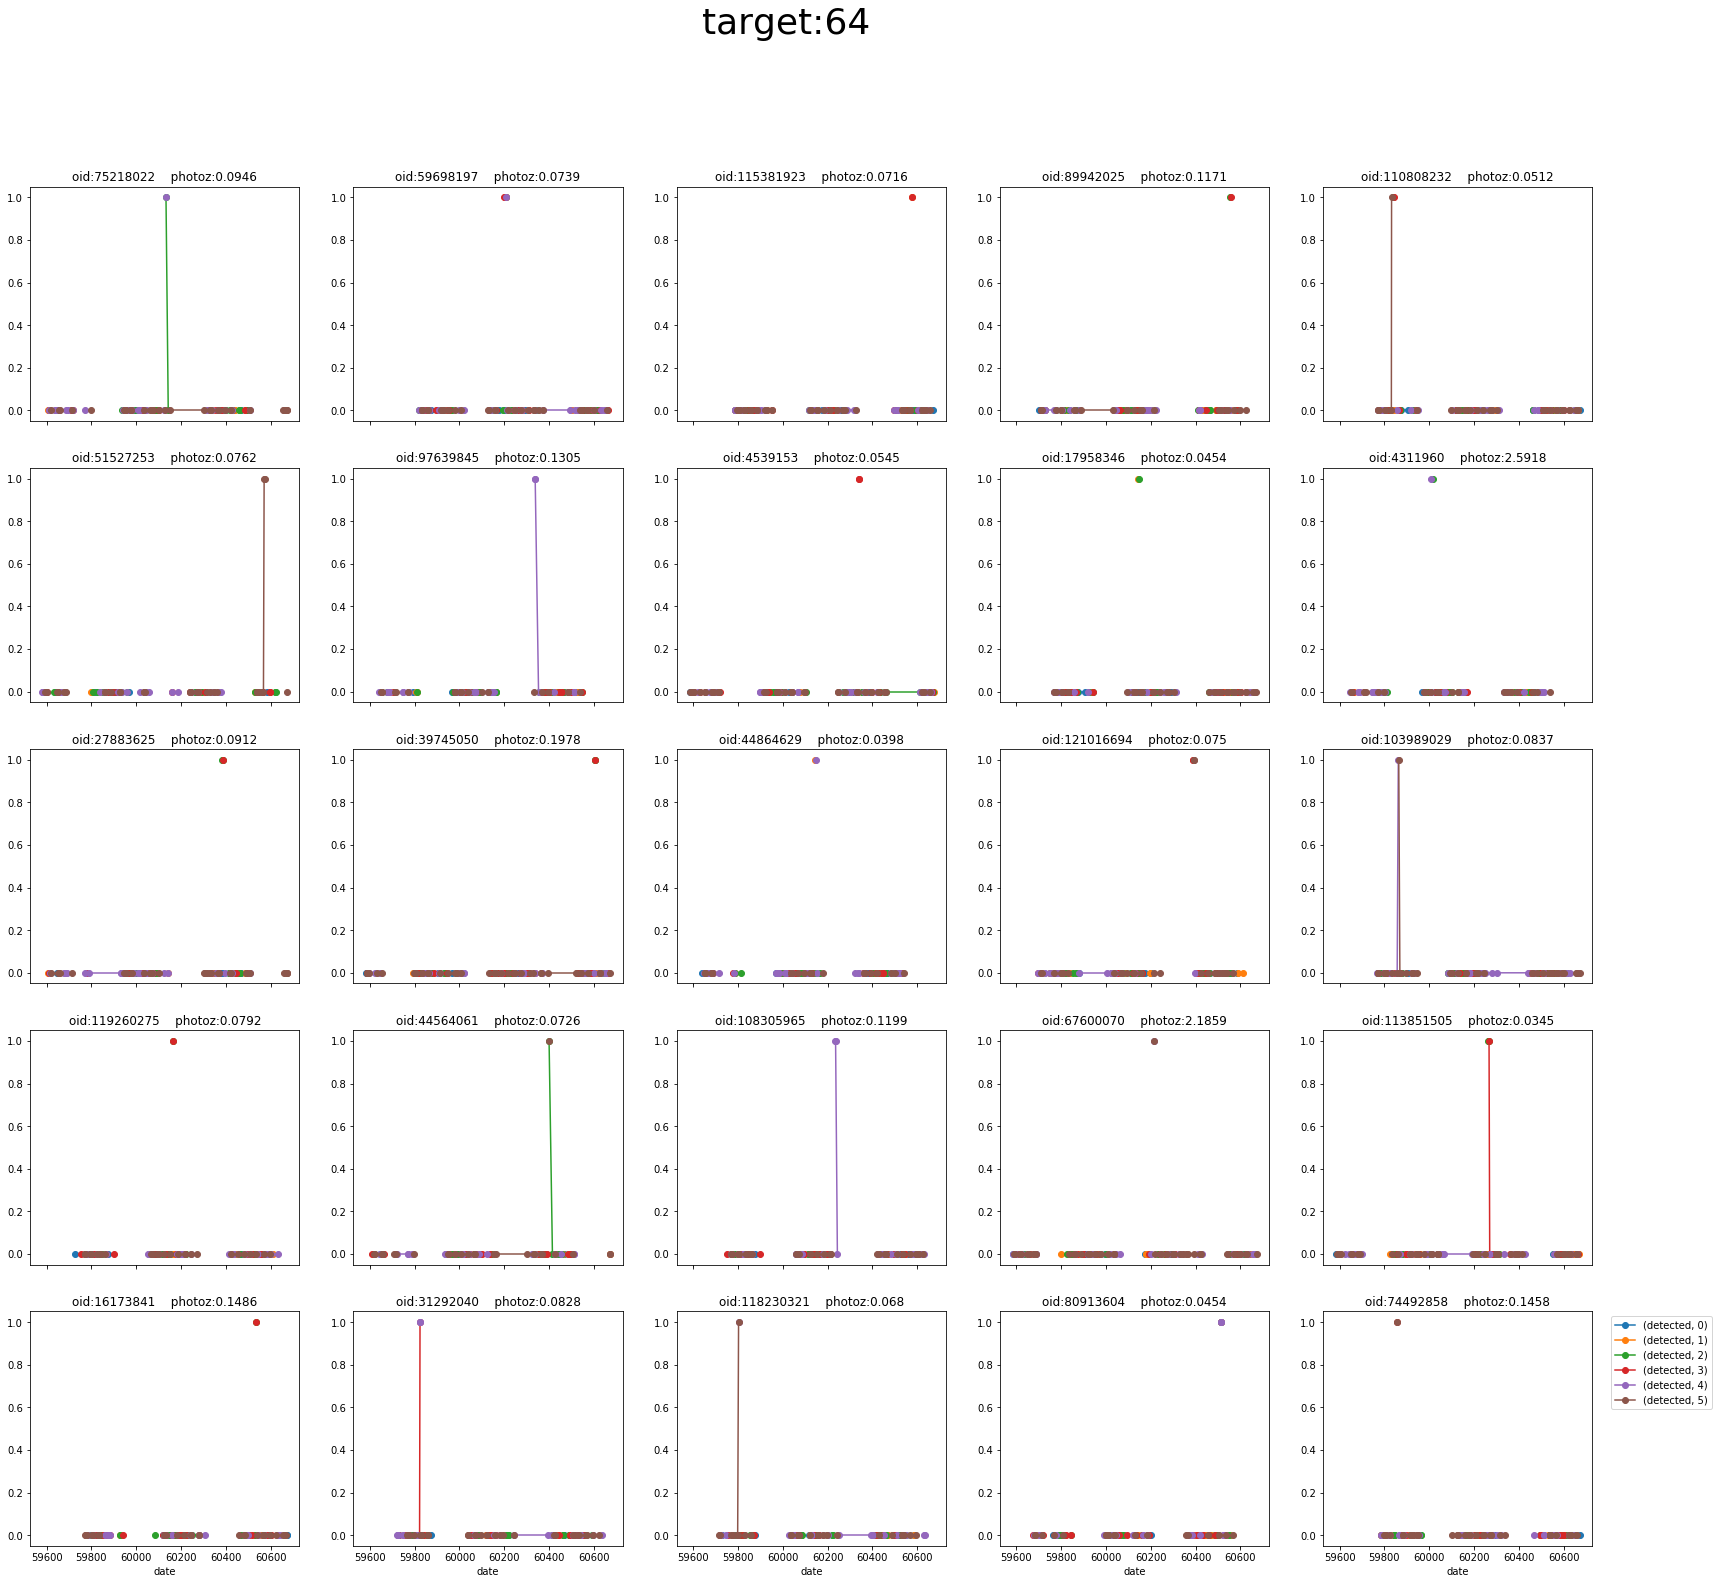

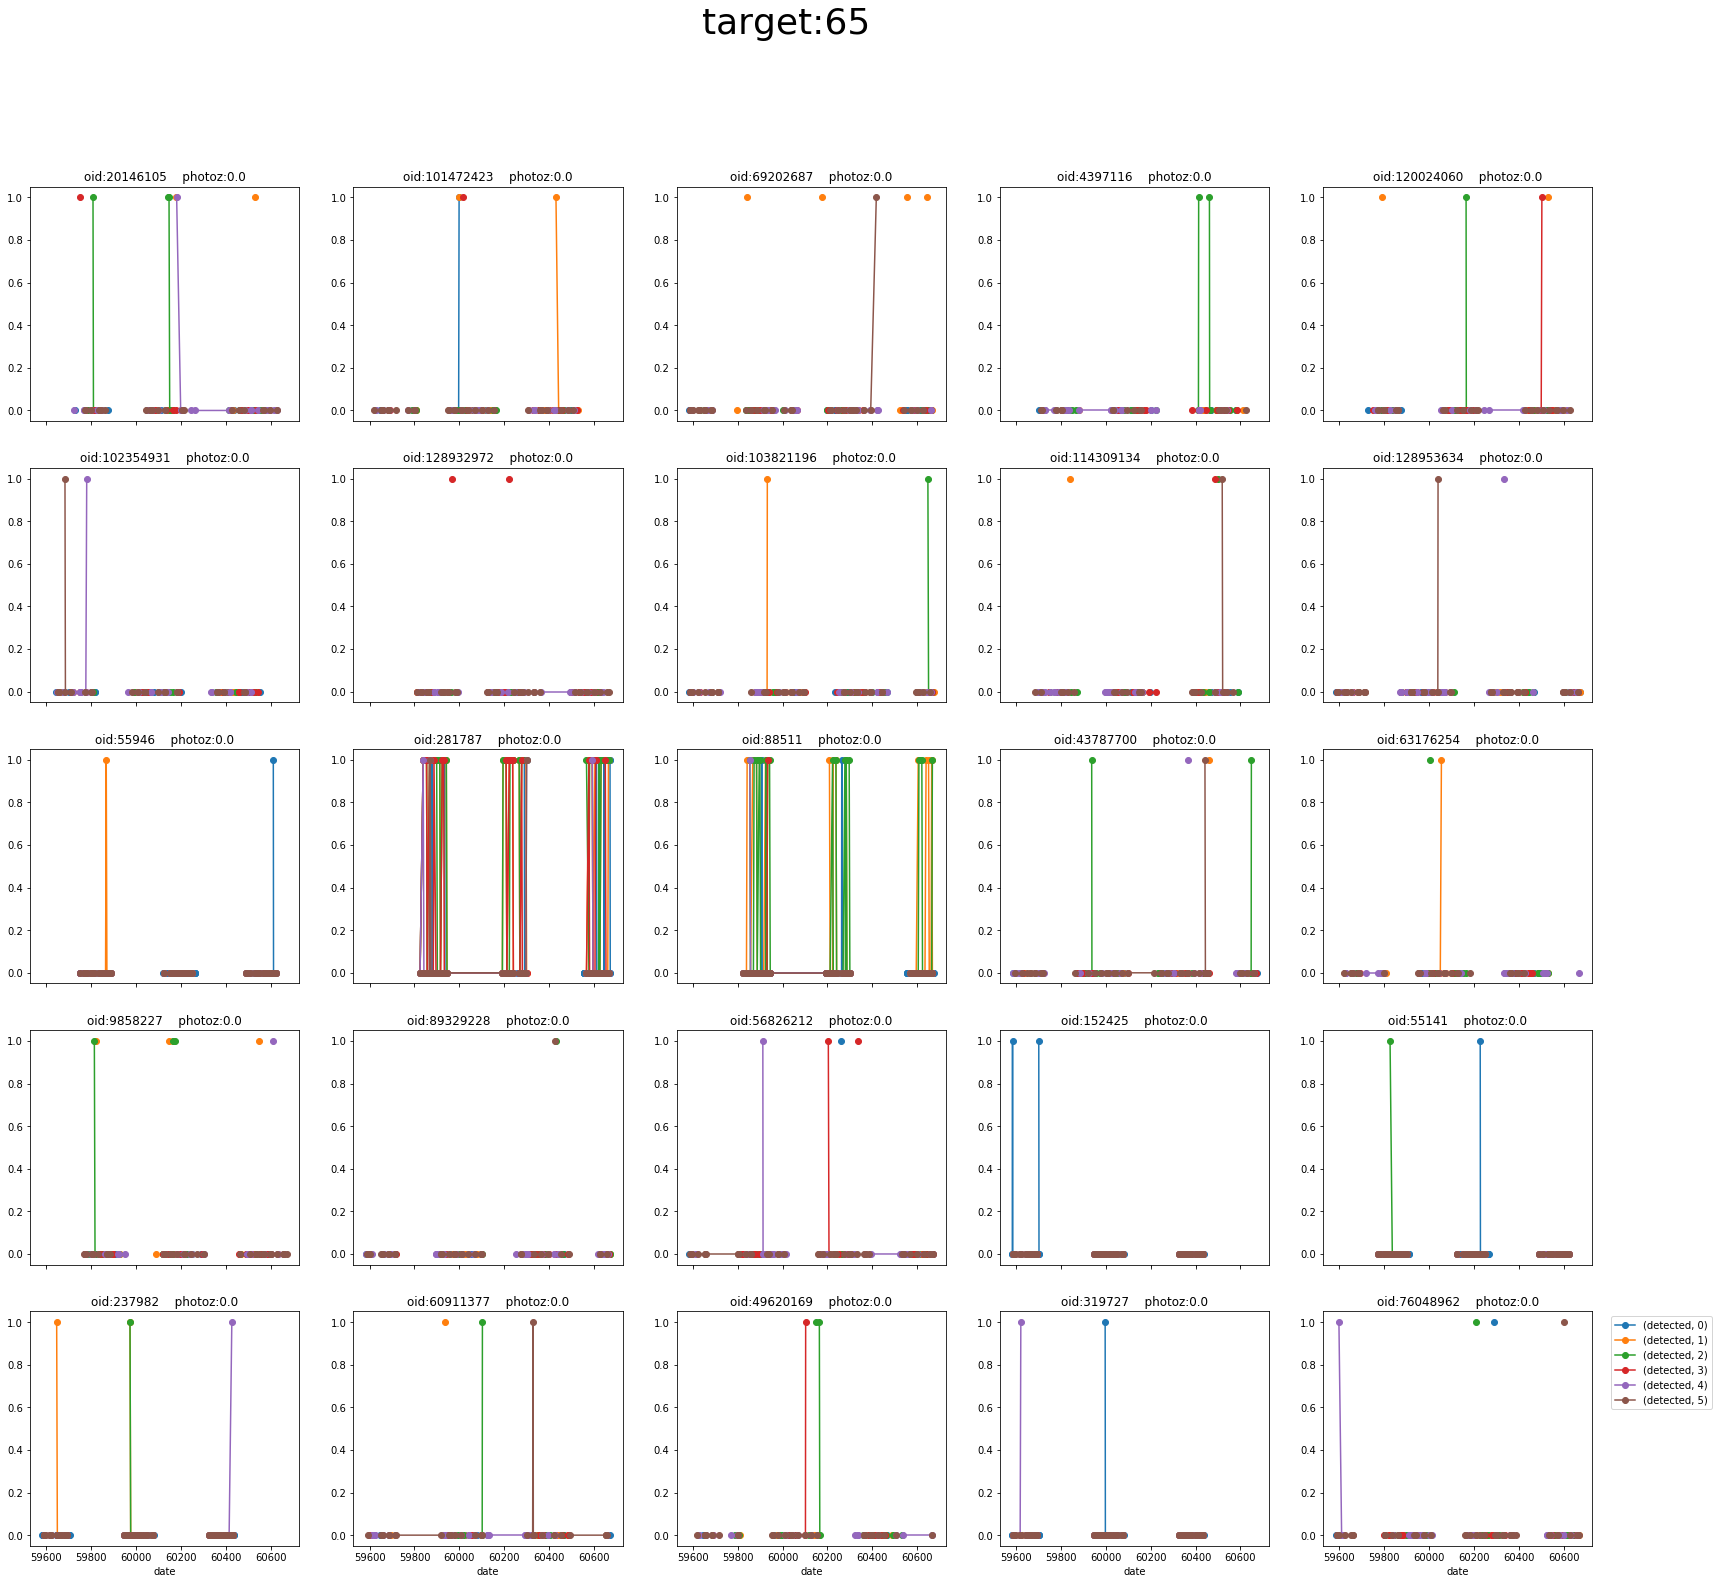

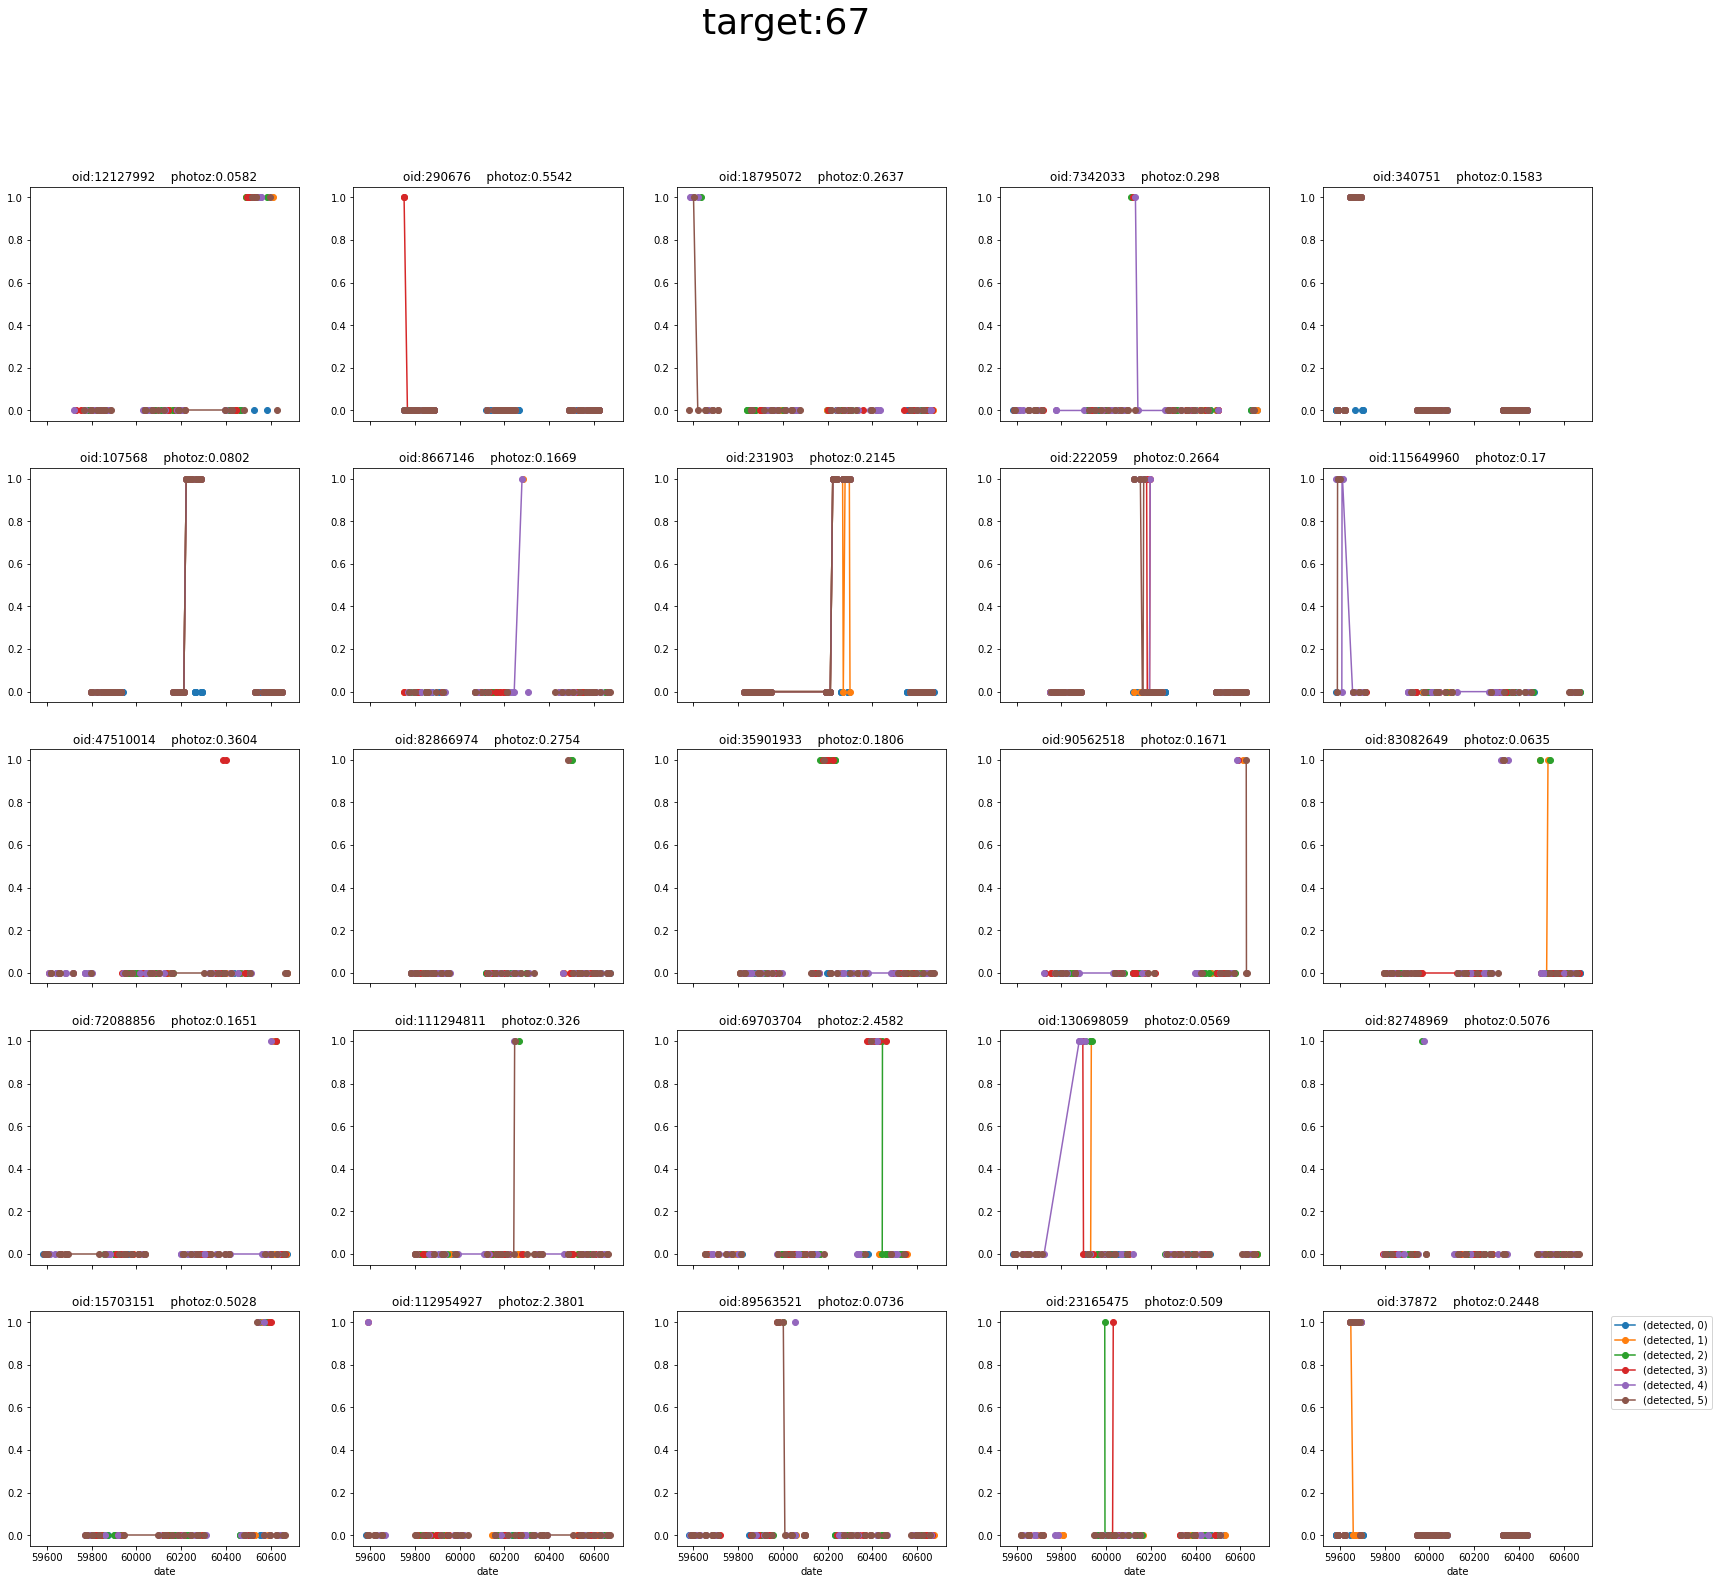

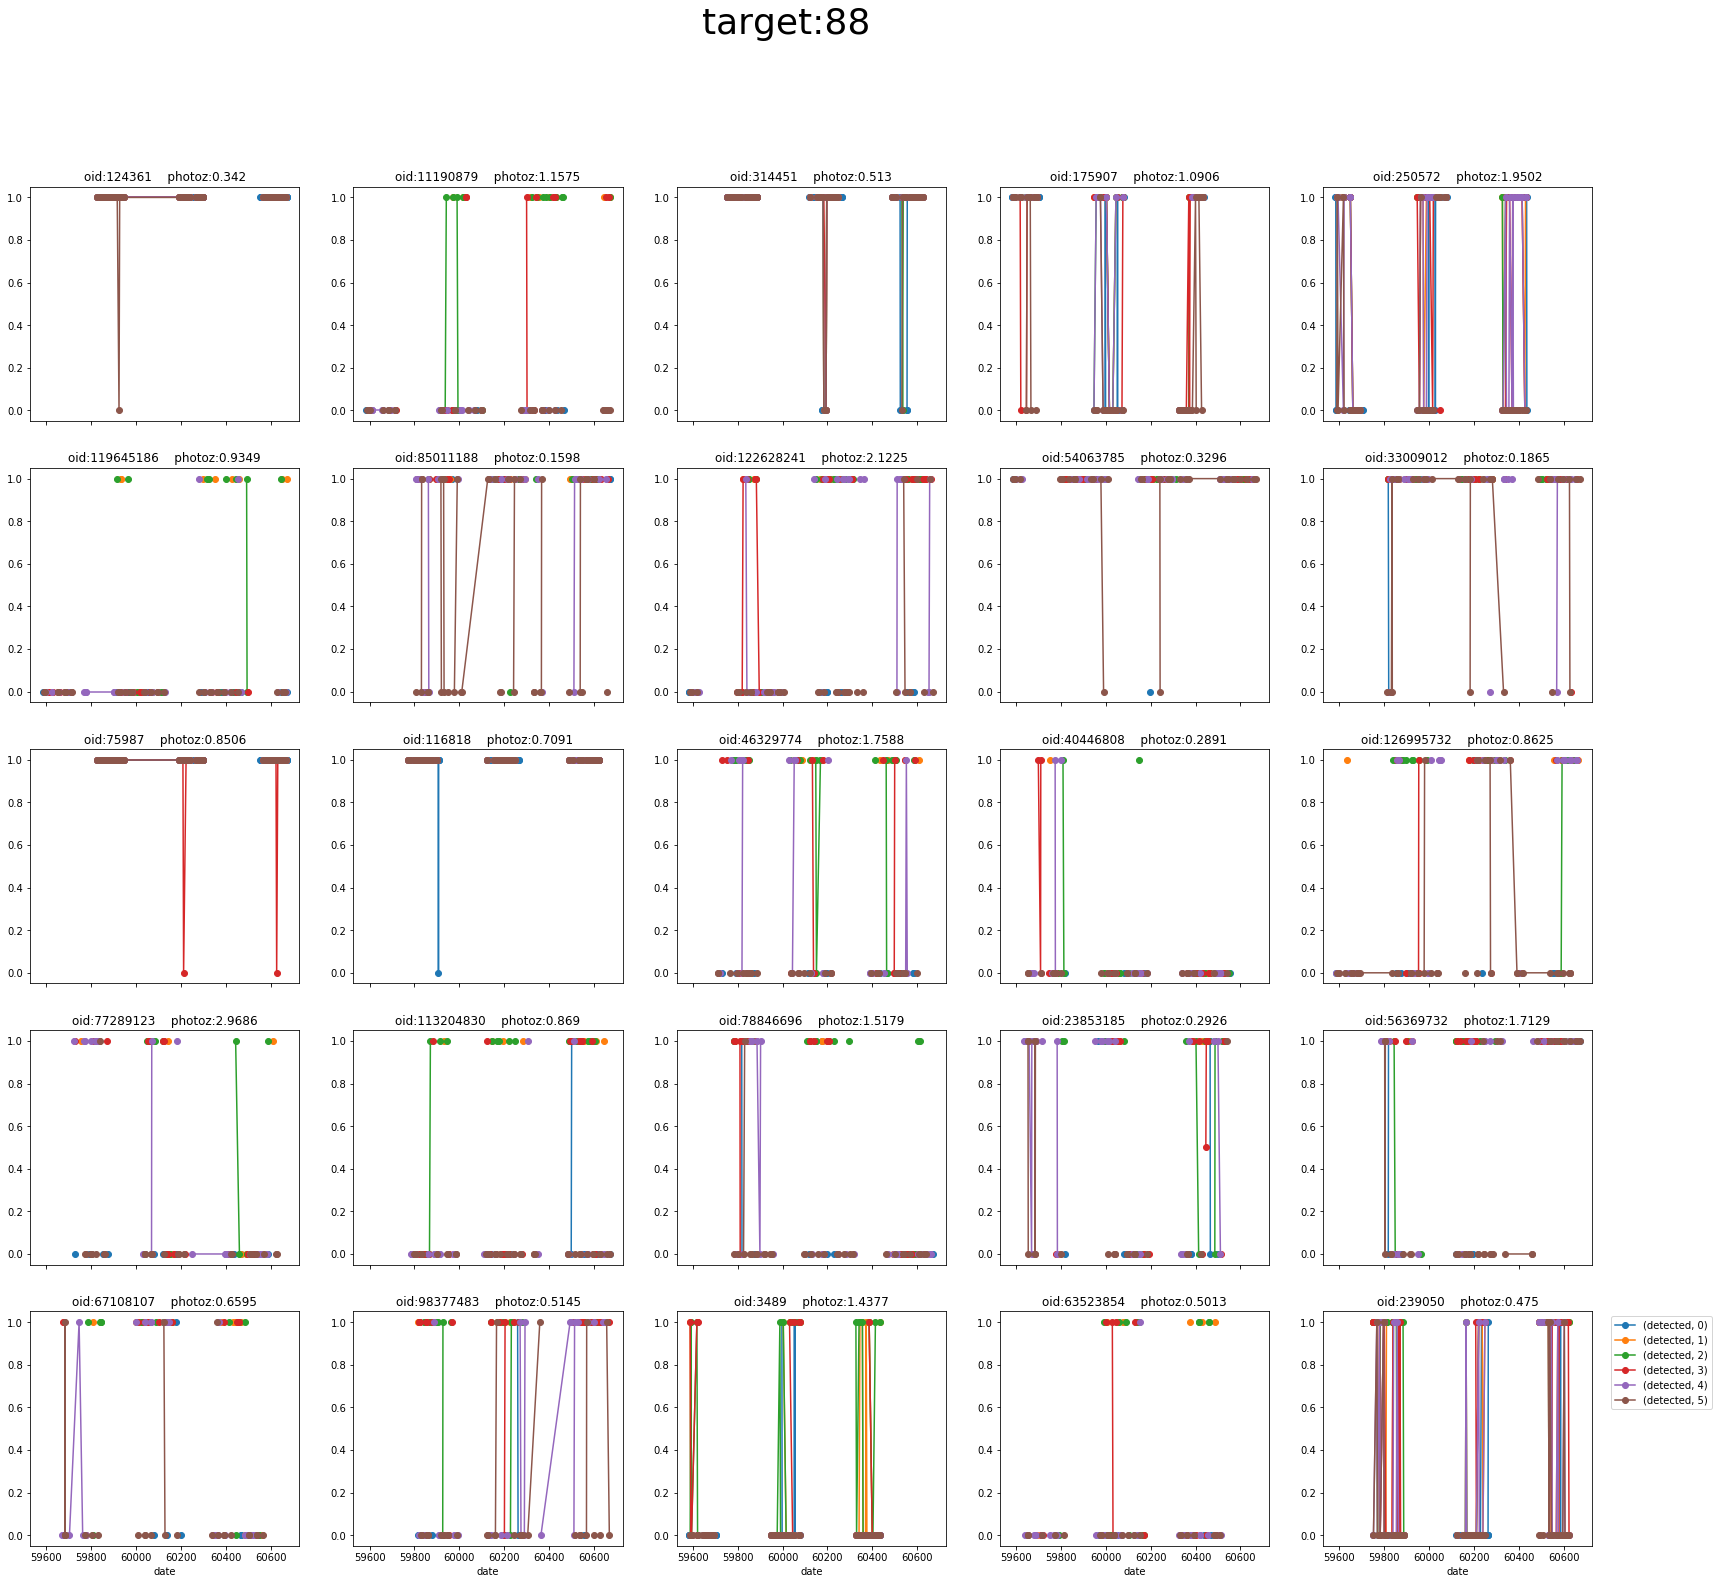

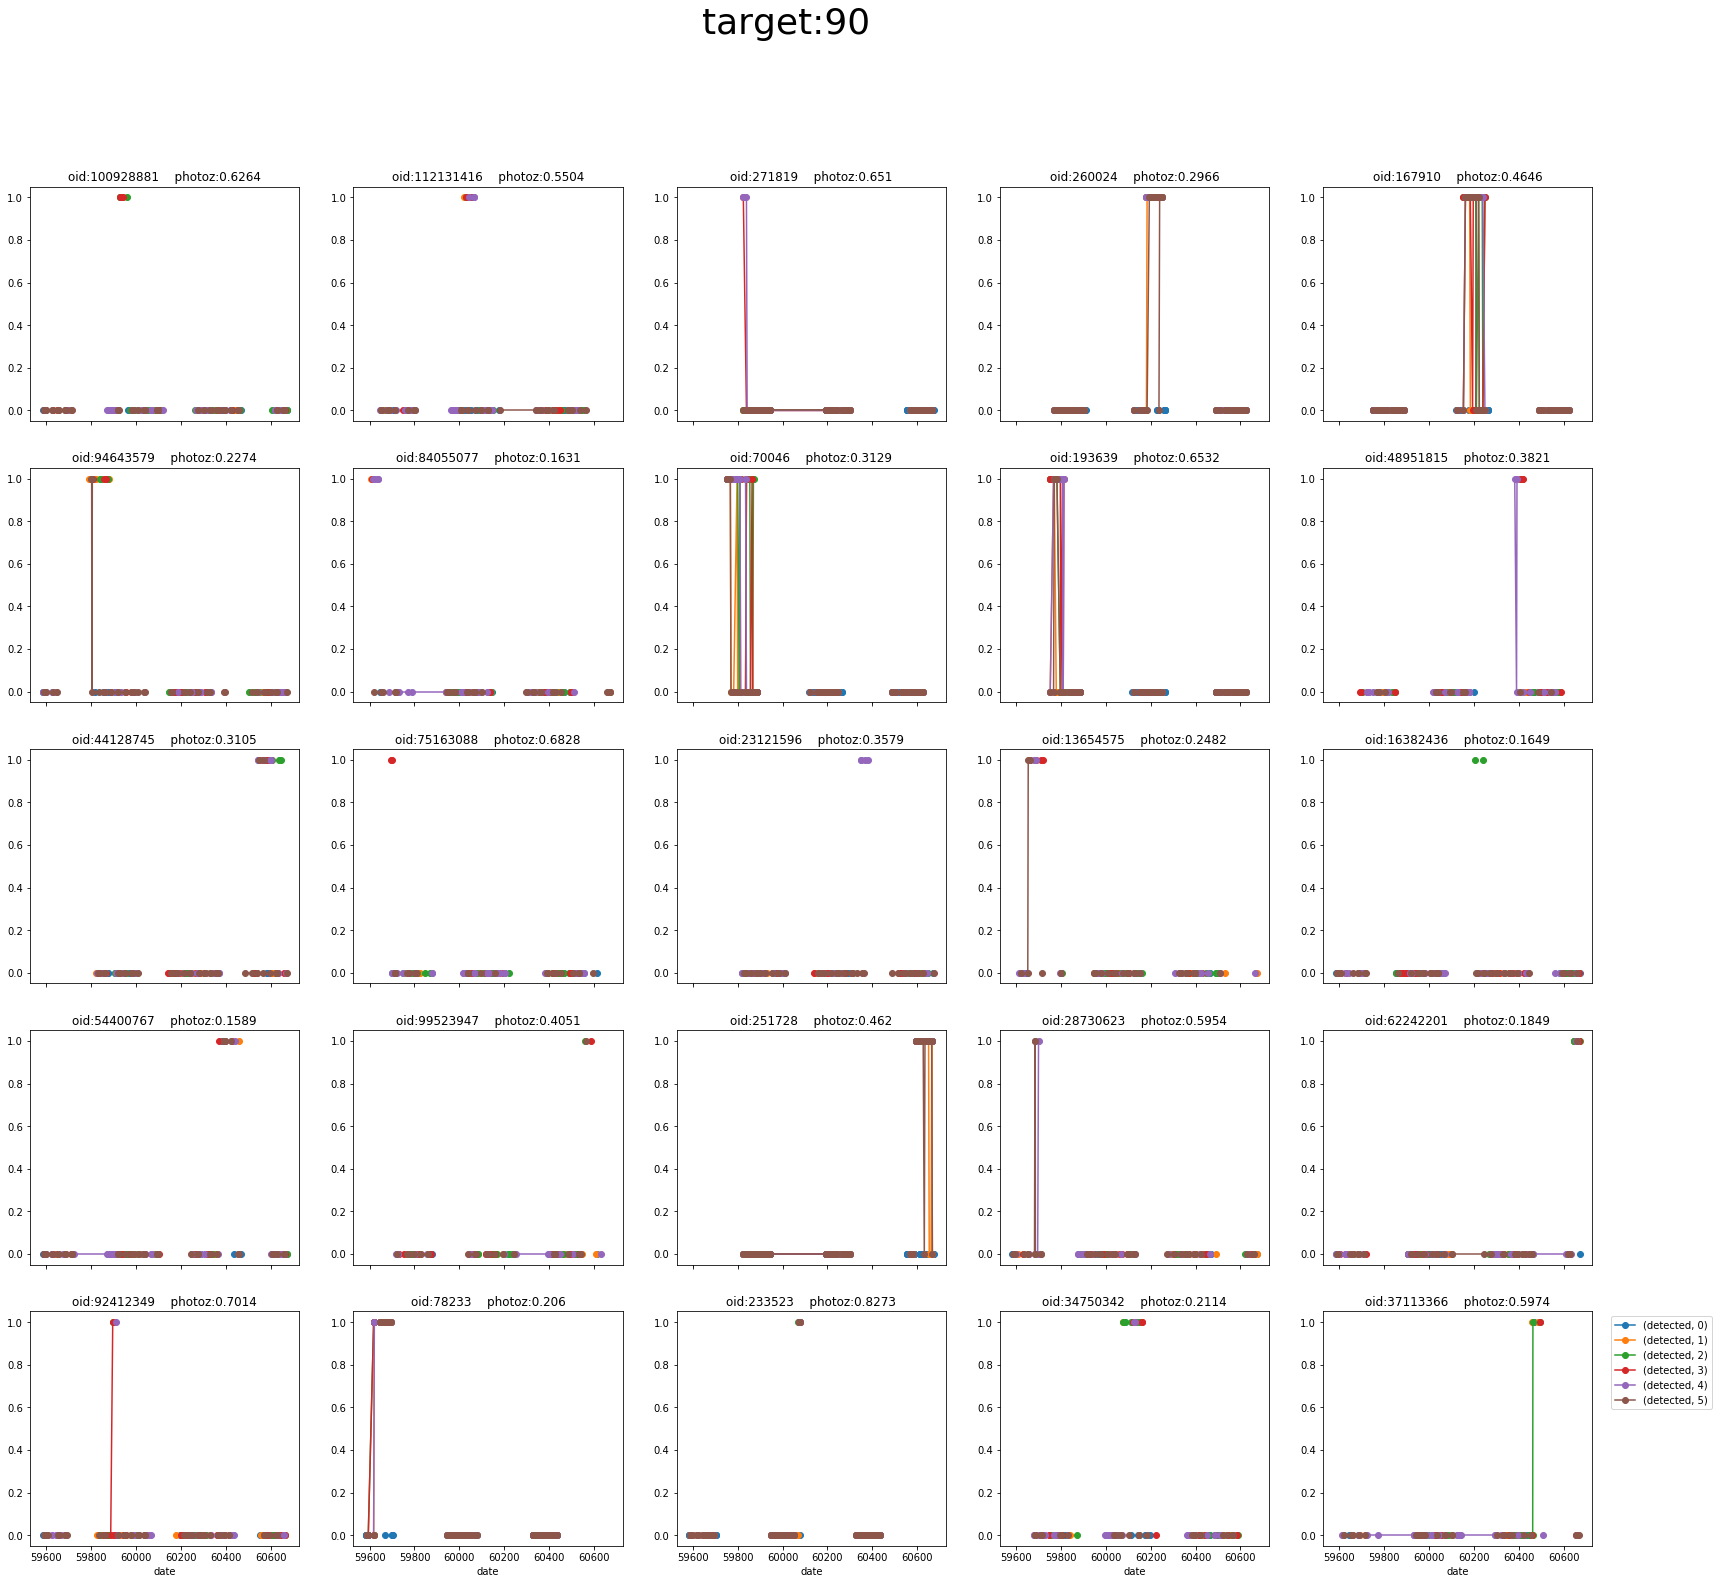

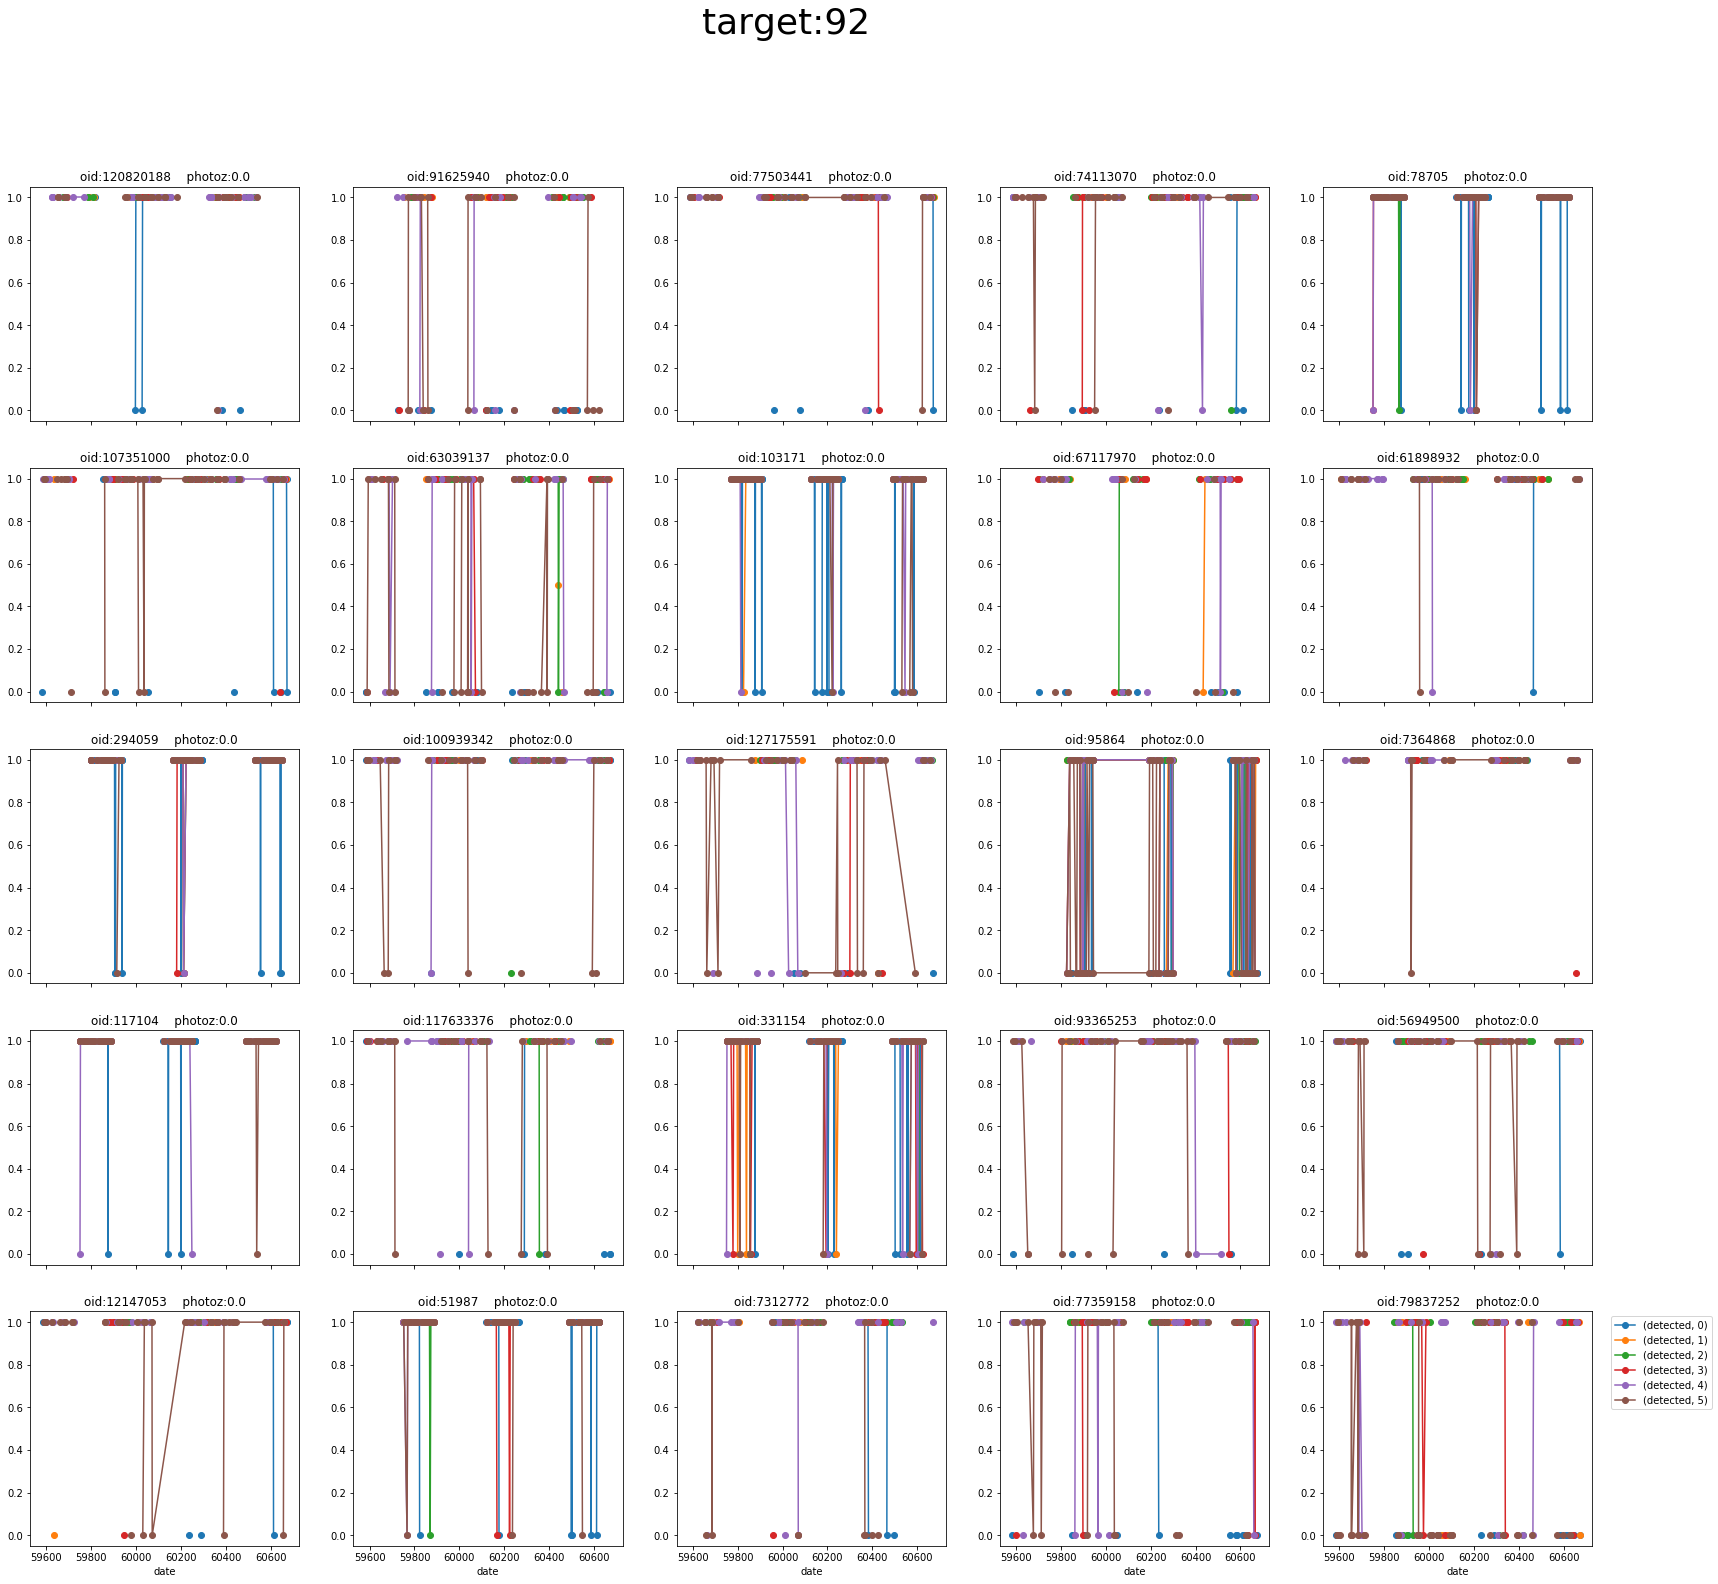

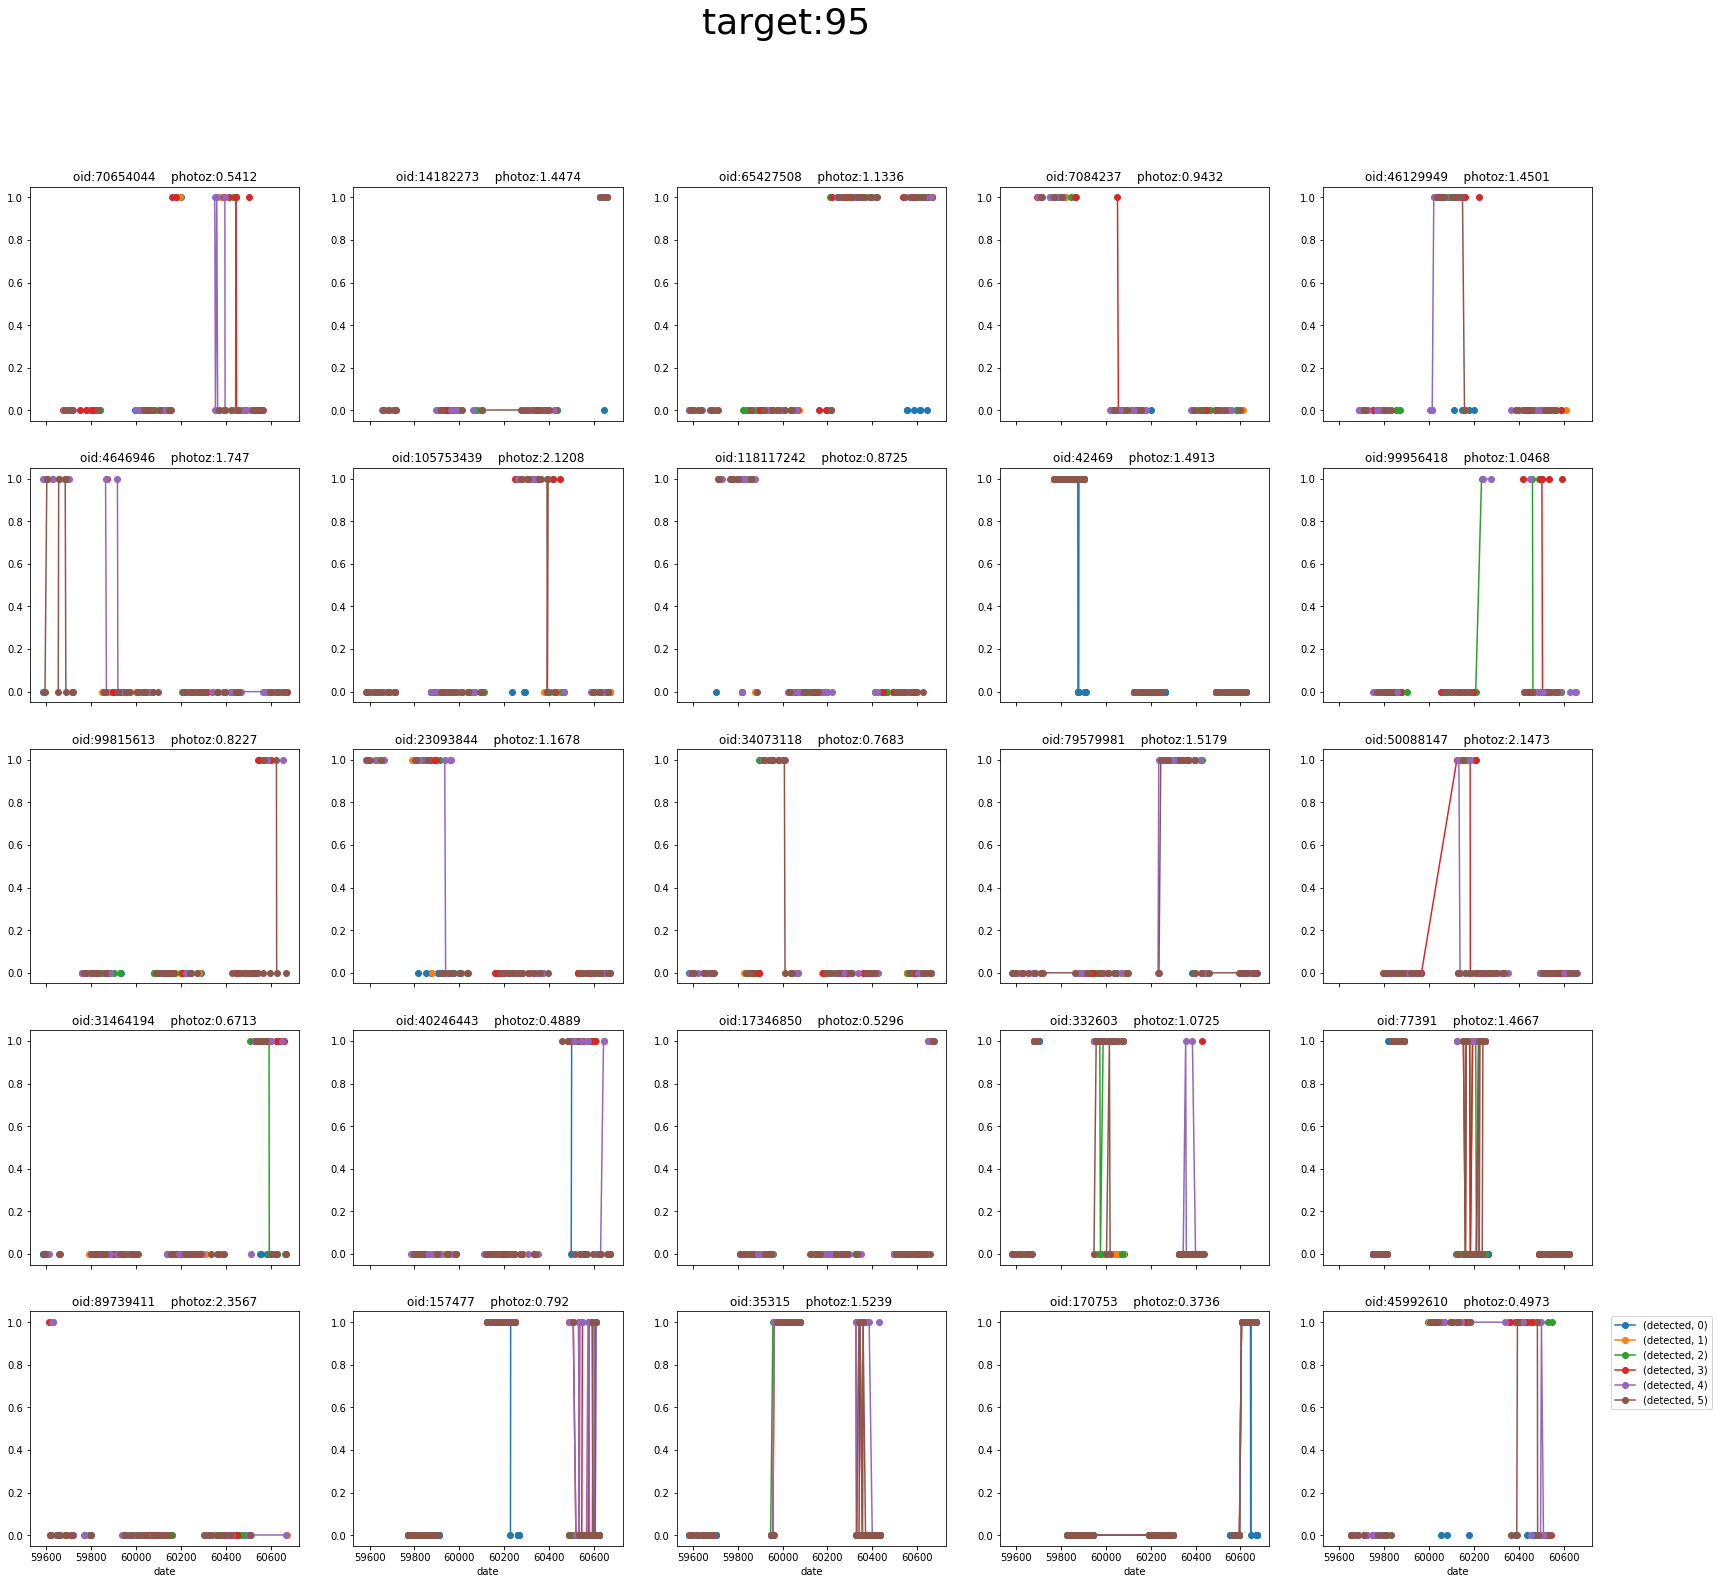

In [8]:
classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
M, N = 5, 5
for c in tqdm(classes):
    li = tr[tr.target==c].sample(M*N).object_id.tolist()
    fig, axes = plt.subplots(ncols=M, nrows=N, figsize=(28, 25), sharex=True)
    
    # プロット
    for i,(ax, oid) in enumerate(zip(axes.ravel(), li)):
        df=plt_obj(oid, return_df=True)

        photoz = tr.loc[tr.object_id==oid, 'hostgal_photoz'].values[0]

        if i==24:
            legend=True
        else:
            legend = False
        df.plot(ax=ax,  marker="o", legend=legend, title=f'oid:{oid}    photoz:{photoz}')
    
    fig.suptitle(f'target:{c}', fontsize=36)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    